# 2024-01-30 30 - Implementing gridsearch and analyzing its impact.ipynb
Implement a gridsearch for constant constraint types with different constraint levels, and see how the results table look versus ERM.

## Parameters

## Libraries and setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex

In [4]:
from utils import wandb_utils

## Data Download

In [8]:
# run_ids = ["lm3mgoih","eadfd56r","ch51utvf","04wd1ye4","f1nskboj","10oxsgx6"]
# df = wandb_utils.get_experiment_data("Autoformer","alelab",experiment_tags=[],query_dict={ "name": {"$in": run_ids}})

100%|██████████| 6/6 [00:25<00:00,  4.30s/it]

Fetched 6 runs
Total records: (6048, 82)
Total runs: 6


In [109]:
real_df = wandb_utils.get_experiment_data("Autoformer","alelab",experiment_tags=[],query_dict={"$and": [
                        {"tags": {"$in": ["e16_finaljan_allerm_replicated","e18_icml_constant_constrained_loose","e17_finaljan_constant_constrained_replicated"]}},
                        {"state": "finished"},
                        {"config.seed": 2021}
        ]})

100%|██████████| 331/331 [24:49<00:00,  4.50s/it]


Fetched 331 runs
Total records: (331344, 82)
Total runs: 331


In [ ]:
experiment_tags = ['e16_finaljan_allerm_replicated',
'e17_finaljan_constant_constrained_replicated',
'e18_icml_constant_constrained_loose',
'e19_icml_resilience_val',
'e19_icml_resilience_train',
'e20_icml_monotonic',
'e20_icml_monotonic_no_resilience',
'e21_icml_static_linear_no_resilience',
'e21_icml_static_linear_resilience',]

backup_data=wandb_utils.get_experiment_data("Autoformer","alelab",experiment_tags=experiment_tags,query_dict={"$and": [
                        {"tags": {"$in": experiment_tags}},
                        {"state": "finished"},
                        {"config.seed": 2021}
        ]})

In [110]:
real_df.to_csv("run_data_cache_icml_constant_constrained_noresilience.csv",index=False)

In [116]:
real_df.to_pickle("run_data_cache_icml_constant_constrained_noresilience.pkl")

In [5]:
real_df = pd.read_pickle("run_data_cache_icml_constant_constrained_noresilience.pkl")

In [6]:
# small_data_backup = df.copy() #the 6 runs tiny one

NameError: name 'df' is not defined

In [7]:
df = real_df

In [8]:
#df = raw_df.copy()
raw_df = df.copy()

In [9]:
#TODO deleteme
df = df[df.seed==2021].copy()
df.run_id.nunique()

331

In [11]:
df.groupby(['data_path','model','pred_len','seed'])['run_id'].nunique().reset_index()

data_path        model  pred_len  seed  run_id
0     electricity.csv   Autoformer        96  2021       7
1     electricity.csv   Autoformer       192  2021       7
2     electricity.csv   Autoformer       336  2021       7
3     electricity.csv   Autoformer       720  2021       7
4     electricity.csv     Informer        96  2021       7
5     electricity.csv     Informer       192  2021       7
6     electricity.csv     Informer       336  2021       7
7     electricity.csv     Informer       720  2021       7
8     electricity.csv     Reformer        96  2021       7
9     electricity.csv     Reformer       192  2021       6
10    electricity.csv     Reformer       336  2021       7
11    electricity.csv     Reformer       720  2021       7
12    electricity.csv  Transformer        96  2021       7
13    electricity.csv  Transformer       192  2021       7
14    electricity.csv  Transformer       336  2021       7
15    electricity.csv  Transformer       720  2021       7
16  exchange_rate.csv   Autoformer        96  2021       7
17  exchange_rate.csv   Autoformer       192  2021       7
18  exchange_rate.csv   Autoformer       336  2021       7
19  exchange_rate.csv   Autoformer       720  2021       7
20  exchange_rate.csv     Informer        96  2021       7
21  exchange_rate.csv     Informer       192  2021       7
22  exchange_rate.csv     Informer       336  2021       7
23  exchange_rate.csv     Informer       720  2021       7
24  exchange_rate.csv     Reformer        96  2021       7
25  exchange_rate.csv     Reformer       192  2021       7
26  exchange_rate.csv     Reformer       336  2021       7
27  exchange_rate.csv     Reformer       720  2021       7
28  exchange_rate.csv  Transformer        96  2021       7
29  exchange_rate.csv  Transformer       192  2021       7
30  exchange_rate.csv  Transformer       336  2021       7
31  exchange_rate.csv  Transformer       720  2021       7
32        weather.csv   Autoformer        96  2021       7
33        weather.csv   Autoformer       192  2021       7
34        weather.csv   Autoformer       336  2021       7
35        weather.csv   Autoformer       720  2021       4
36        weather.csv     Informer        96  2021       7
37        weather.csv     Informer       192  2021       7
38        weather.csv     Informer       336  2021       7
39        weather.csv     Informer       720  2021       7
40        weather.csv     Reformer        96  2021       6
41        weather.csv     Reformer       192  2021       7
42        weather.csv     Reformer       336  2021       7
43        weather.csv     Reformer       720  2021       7
44        weather.csv  Transformer        96  2021       7
45        weather.csv  Transformer       192  2021       7
46        weather.csv  Transformer       336  2021       7
47        weather.csv  Transformer       720  2021       7

In [12]:
runs_per_groupset=df.groupby(['data_path','model','pred_len','seed'])['run_id'].nunique().reset_index()
runs_per_groupset[runs_per_groupset.run_id!=7]

data_path       model  pred_len  seed  run_id
9   electricity.csv    Reformer       192  2021       6
35      weather.csv  Autoformer       720  2021       4
40      weather.csv    Reformer        96  2021       6

## Data processing
This section contains processing specific to this experiment set. If you clone this notebook. Remove or refactor this section.

## Gridsearch function (todo extract into script)
Meant to be used on `df_constrained` (containing only constant constrained `df`)

In [23]:
def gridsearch(runs_df, objective_col, gridsearch_keys, reference_cols, split='val',mode='mean'):
    """
    Performs a gridsearch across the runs under `gridsearch_keys`, with the objective of minimizing `objective_col`.
    
    Parameters
    ---
    mode: is either 'mean' or 'std', to choose which statistic of the objective value to use for the gridsearch.
    
    Returns 
    ---
    
        the runs_df filtered by the best runs, and the summary metric of the best runs.
    """
    grouped_cols = gridsearch_keys + reference_cols + ['constraint_level'] #todo maybe don't need to hardcode this
    summary_metric = objective_col

    run_gridsearch_stats = runs_df.query(f"split=='{split}'").groupby(grouped_cols).agg(
        mean_objective=(objective_col, 'mean'),
        std_objective=(objective_col, 'std'),
        #mean_constraint_violation=('constraint_violation', 'mean'), #is it worth having other stuff here?
        count=('step', 'size')
    ).reset_index().sort_values(['model', 'std_objective'])

    best_runs = run_gridsearch_stats.groupby(gridsearch_keys)[f'{mode}_objective'].idxmin()
    best_runs_df = run_gridsearch_stats.loc[best_runs, :]
    filtered_runs_df = runs_df[runs_df['run_id'].isin(best_runs_df['run_id'].unique())] #TODO run_id is a hard requirement in the group cols.

    return filtered_runs_df, best_runs_df[grouped_cols + [f'{mode}_objective']]

### Label constraint_levels (`constraint_idx` column)
useful for joining when the constraint values are different for each model.

In [24]:
# There are three constraint levels per run, add a rank column, sorted by constraint level.
df=df.copy()#df_constrained.copy()
#display(df[['seed','data_path','model','pred_len','constraint_level']].drop_duplicates().sort_values(['data_path','model','pred_len','constraint_level']).head())
df.loc[df.constraint_type=='constant','constraint_idx'] = df.query('constraint_type=="constant"').groupby(['seed','data_path','model','pred_len'])['constraint_level'].rank(method='dense', ascending=True).astype(int)
df.loc[df.constraint_type=='erm','constraint_idx'] = 0
df['constraint_idx'] = df['constraint_idx'].astype(int)
ranked_constraint_levels_summary = df[['run_id','data_path','model','pred_len','constraint_type','constraint_level','constraint_idx']].drop_duplicates('run_id').sort_values(['data_path','model','pred_len','constraint_level'])
print("Sanity checking on the summary")
ranked_constraint_levels_summary

Sanity checking on the summary


run_id        data_path        model  pred_len constraint_type  \
314928  uglzgsuo  electricity.csv   Autoformer        96             erm   
232560  idtz7hic  electricity.csv   Autoformer        96        constant   
232272  c4z5umai  electricity.csv   Autoformer        96        constant   
231984  tickbccb  electricity.csv   Autoformer        96        constant   
98640   3cluutoj  electricity.csv   Autoformer        96        constant   
...          ...              ...          ...       ...             ...   
235008  lk945020      weather.csv  Transformer       720        constant   
232848  ossb6hui      weather.csv  Transformer       720        constant   
103536  zjxaal2j      weather.csv  Transformer       720        constant   
101376  o4wl3w36      weather.csv  Transformer       720        constant   
99216   5m97mw25      weather.csv  Transformer       720        constant   

        constraint_level  constraint_idx  
314928            -1.000               0  
232560             0.113               1  
232272             0.117               2  
231984             0.120               3  
98640              0.151               4  
...                  ...             ...  
235008             0.215               2  
232848             0.216               3  
103536             0.787               4  
101376             0.972               5  
99216              1.035               6  

[331 rows x 7 columns]

### Broadcast ERM runs with constraint levels and add gridsearch (`df_to_plot`)
to compare ERM with constrained, we need every ERM run repeated to pair it with a constrained run.

In [25]:
df_constrained = df.query('type=="Constrained"').copy()
df_constrained,best_runs = gridsearch(df_constrained,objective_col='mse', gridsearch_keys=['model', 'pred_len', 'data_path'],reference_cols=['run_id'],split='val')
df_erm = df.query('type=="ERM"').copy()
#(data_path,model,pred_len,constraint_level,constrained_unconstraled)
distinct_constraints = df_constrained[['data_path','model','pred_len','constraint_type']].drop_duplicates()

# crossjoin the ERM mse to all constraint levels
df_erm_w_broadcasted_constraint_levels = df_erm.drop(columns=['constraint_type']).merge(distinct_constraints,on=['data_path','model','pred_len'],how='left')
df_to_plot = pd.concat([df_constrained,df_erm_w_broadcasted_constraint_levels],axis=0)

# sanity check
display(df_erm_w_broadcasted_constraint_levels.shape)
print(f"Three constraints per experiment, broadcasted dataset size be equal to {df_erm.shape[0]*1}")
display(df_to_plot.shape)
print(f"Final dataset size should be equal to {df_constrained.shape[0]+df_erm.shape[0]*1}")

(48384, 83)

Three constraints per experiment, broadcasted dataset size be equal to 48384


(96768, 83)

Final dataset size should be equal to 96768


### Add constraint violation metric

In [26]:
# Adding the constraint violation column
df_to_plot["constraint_violation"] = (df_to_plot.mse-df_to_plot.constraint_level).clip(lower=0)
df_to_plot['is_infeasible'] = (df_to_plot.constraint_violation>0)*1

# sanity check
dd=df_to_plot[['run_id','model','type','step','mse','constraint_level','constraint_violation','is_infeasible']] 
print("For ERM")
display(dd.query('type=="ERM"').query('constraint_violation>0').head())
print("For Constrained")
display(dd.query('type=="Constrained"').query('constraint_violation>0').head())


For ERM


run_id        model type  step       mse  constraint_level  \
0  k6rl9exh  Transformer  ERM     0  0.095688              -1.0   
1  k6rl9exh  Transformer  ERM     1  0.060131              -1.0   
2  k6rl9exh  Transformer  ERM     2  0.058476              -1.0   
3  k6rl9exh  Transformer  ERM     3  0.058762              -1.0   
4  k6rl9exh  Transformer  ERM     4  0.058699              -1.0   

   constraint_violation  is_infeasible  
0              1.095688              1  
1              1.060131              1  
2              1.058476              1  
3              1.058762              1  
4              1.058699              1

For Constrained


run_id        model         type  step       mse  constraint_level  \
6342  ks5yqfbq  Transformer  Constrained   294  2.547692             2.496   
6343  ks5yqfbq  Transformer  Constrained   295  2.722402             2.496   
6344  ks5yqfbq  Transformer  Constrained   296  2.840756             2.496   
6345  ks5yqfbq  Transformer  Constrained   297  2.827039             2.496   
6346  ks5yqfbq  Transformer  Constrained   298  2.685753             2.496   

      constraint_violation  is_infeasible  
6342              0.051692              1  
6343              0.226402              1  
6344              0.344756              1  
6345              0.331039              1  
6346              0.189753              1

### Summary metrics per run
Summarize all three runs into metrics per split by averaging mse and constraint levels.

In [163]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric

summary_metrics_per_run = df_to_plot.groupby([
    "data_path",
    "model",
    "pred_len",
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    'type',
    "constraint_idx",
    "split",
    "constraint_level",
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        window_std=('mse','std'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics = summary_metrics_per_run.groupby([
    "data_path",
    "model",
    "pred_len",
    'type', #ERM or constrained
    "split",
    "Algorithm",
    "constraint_idx",
    "constraint_level",
    ]).aggregate(
        mse=('mse','mean'),
        window_std=('window_std','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run.shape)
display(summary_metrics.shape)
summary_metrics.head()

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


(288, 14)

(288, 16)

data_path       model  pred_len         type  split  \
0  electricity.csv  Autoformer        96  Constrained   test   
1  electricity.csv  Autoformer        96  Constrained  train   
2  electricity.csv  Autoformer        96  Constrained    val   
3  electricity.csv  Autoformer        96          ERM   test   
4  electricity.csv  Autoformer        96          ERM  train   

                              Algorithm  constraint_idx  constraint_level  \
0                electricity Autoformer               1             0.113   
1                electricity Autoformer               1             0.113   
2                electricity Autoformer               1             0.113   
3  AllModels_electricity.csv Autoformer               0            -1.000   
4  AllModels_electricity.csv Autoformer               0            -1.000   

       mse  window_std  std_mse      mcv  std_mcv  mean_infeasible_rate  \
0  0.20018     0.01513      NaN  0.08718      NaN               1.00000   
1  0.11591     0.00943      NaN  0.00407      NaN               0.51042   
2  0.15709     0.01001      NaN  0.04409      NaN               0.99974   
3  0.20399     0.01549      NaN  1.20399      NaN               1.00000   
4  0.11989     0.01159      NaN  1.11989      NaN               1.00000   

   std_infeasible_rate  run_count  
0                  NaN        1.0  
1                  NaN        1.0  
2                  NaN        1.0  
3                  NaN        1.0  
4                  NaN        1.0

**END OF PREPROCESSING**

---
---

## Plots

### ERM vs. Constrained on 50th percentile (one seed)
TO DO: Reproduce the ERM vs constrained per model for each window size. Try to unify into one plot if possible.

#### **ERM Vs Constrained 96 (split=test)**

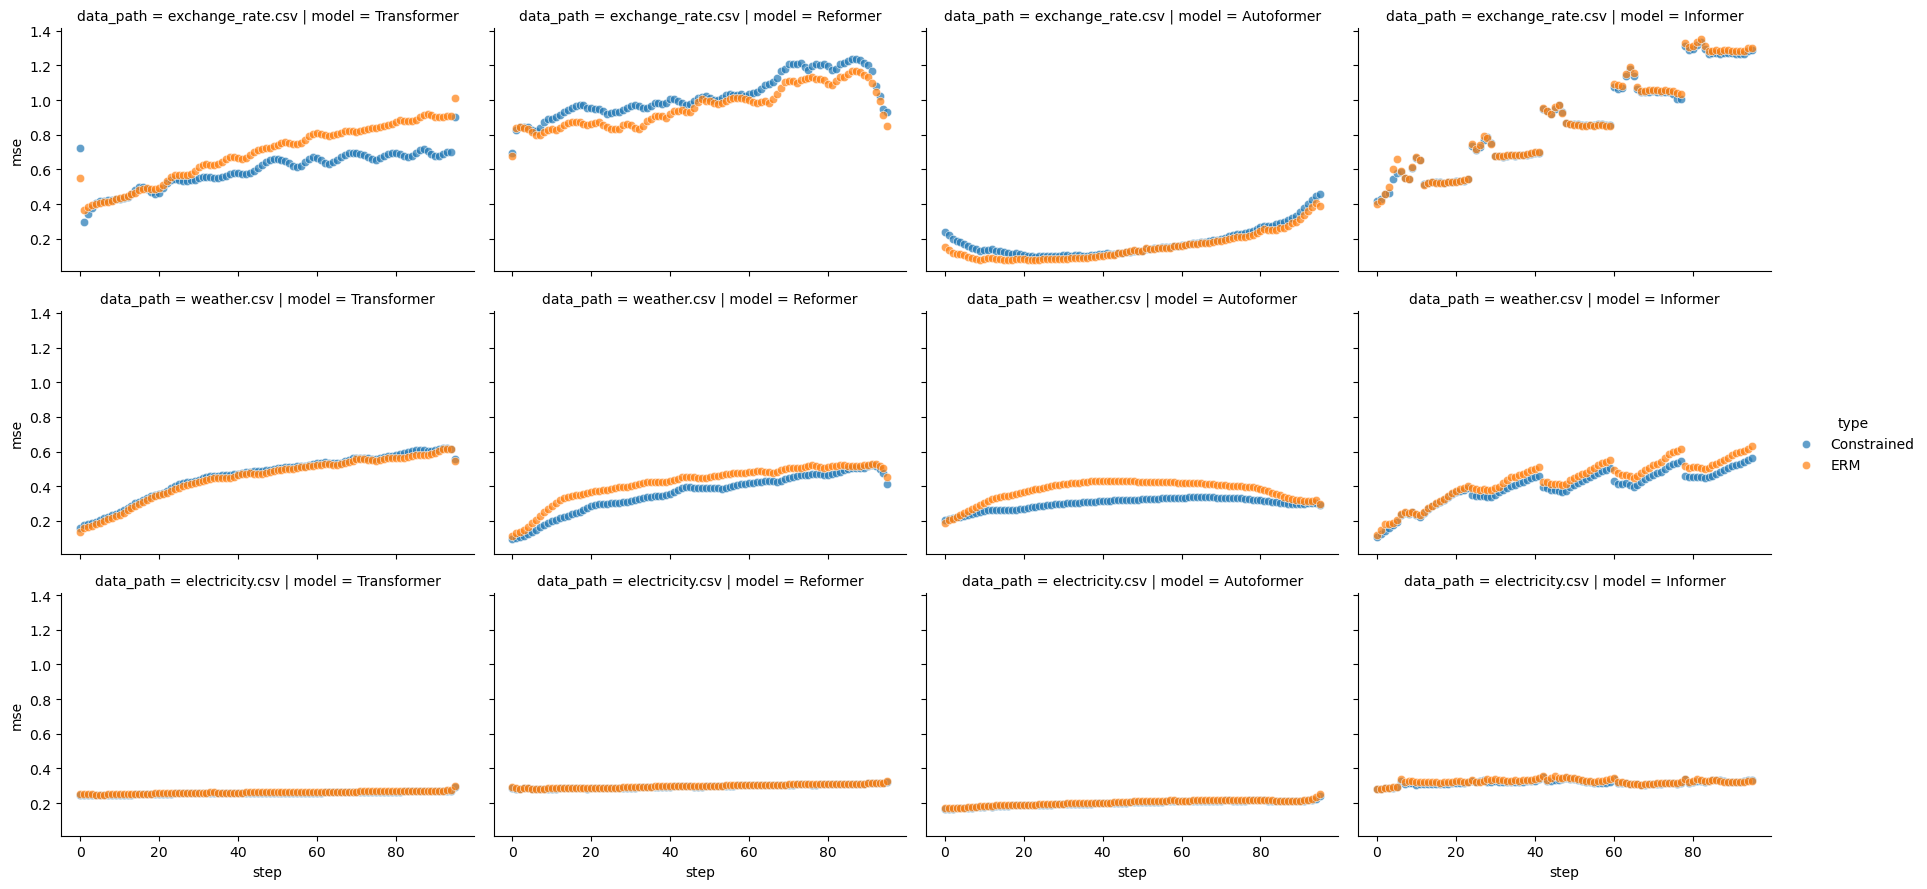

#### **ERM Vs Constrained 192 (split=test)**

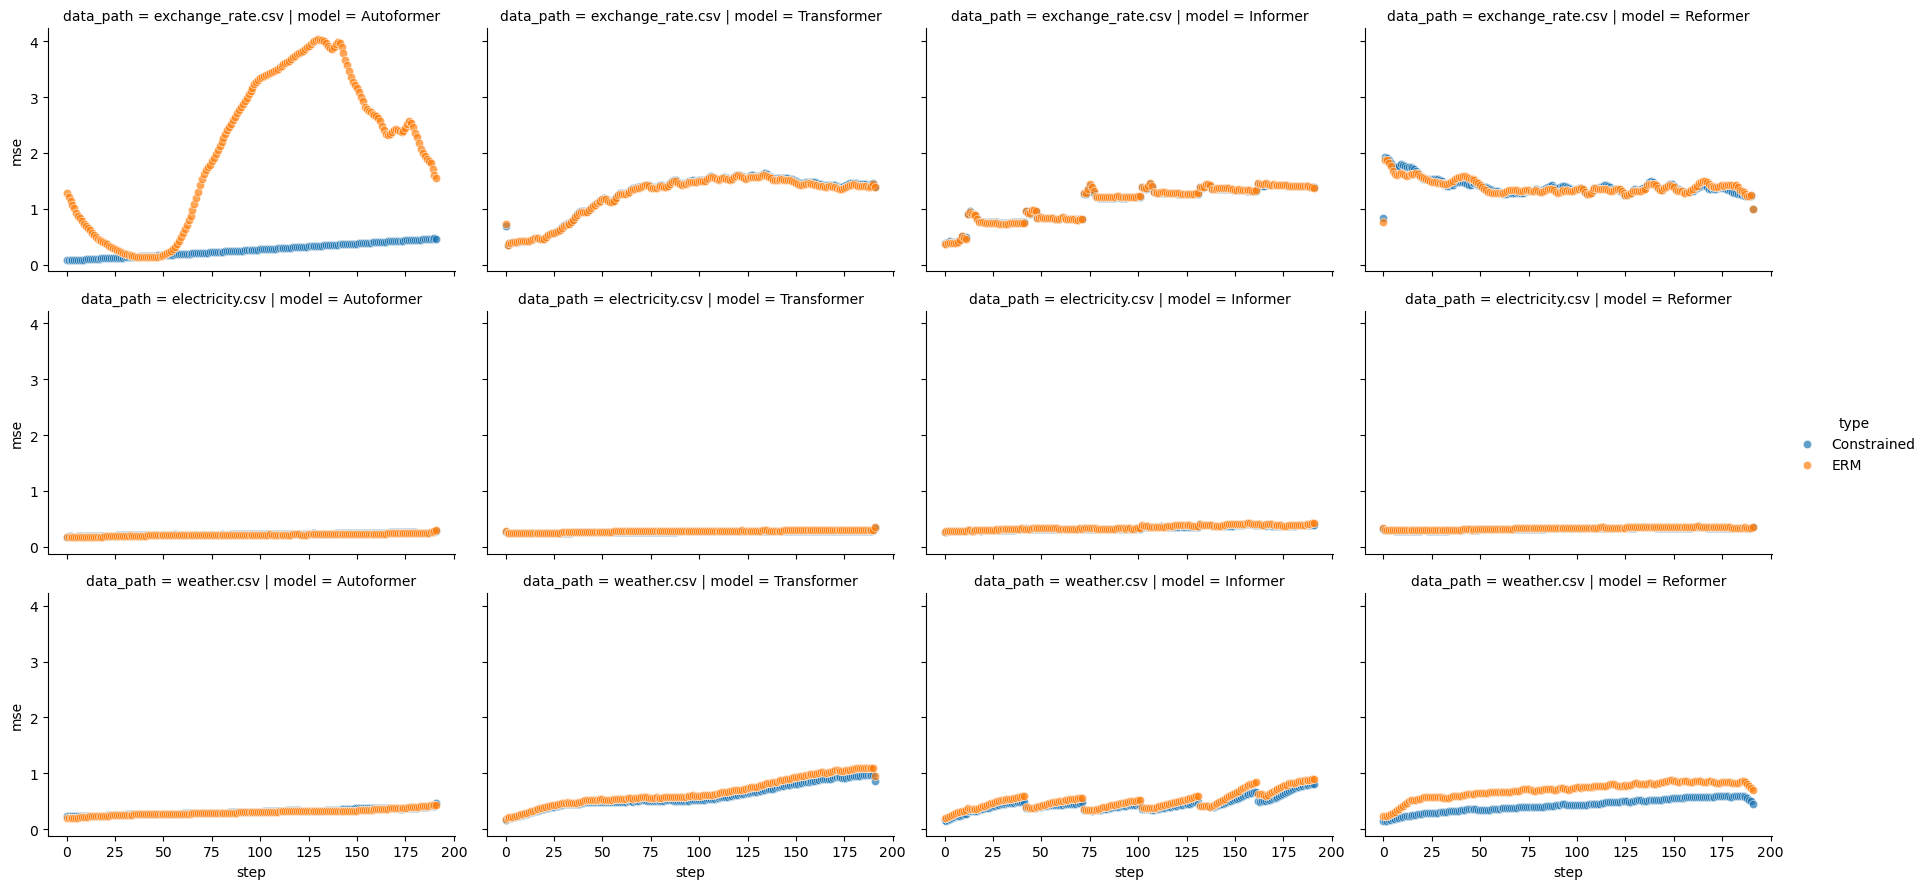

#### **ERM Vs Constrained 336 (split=test)**

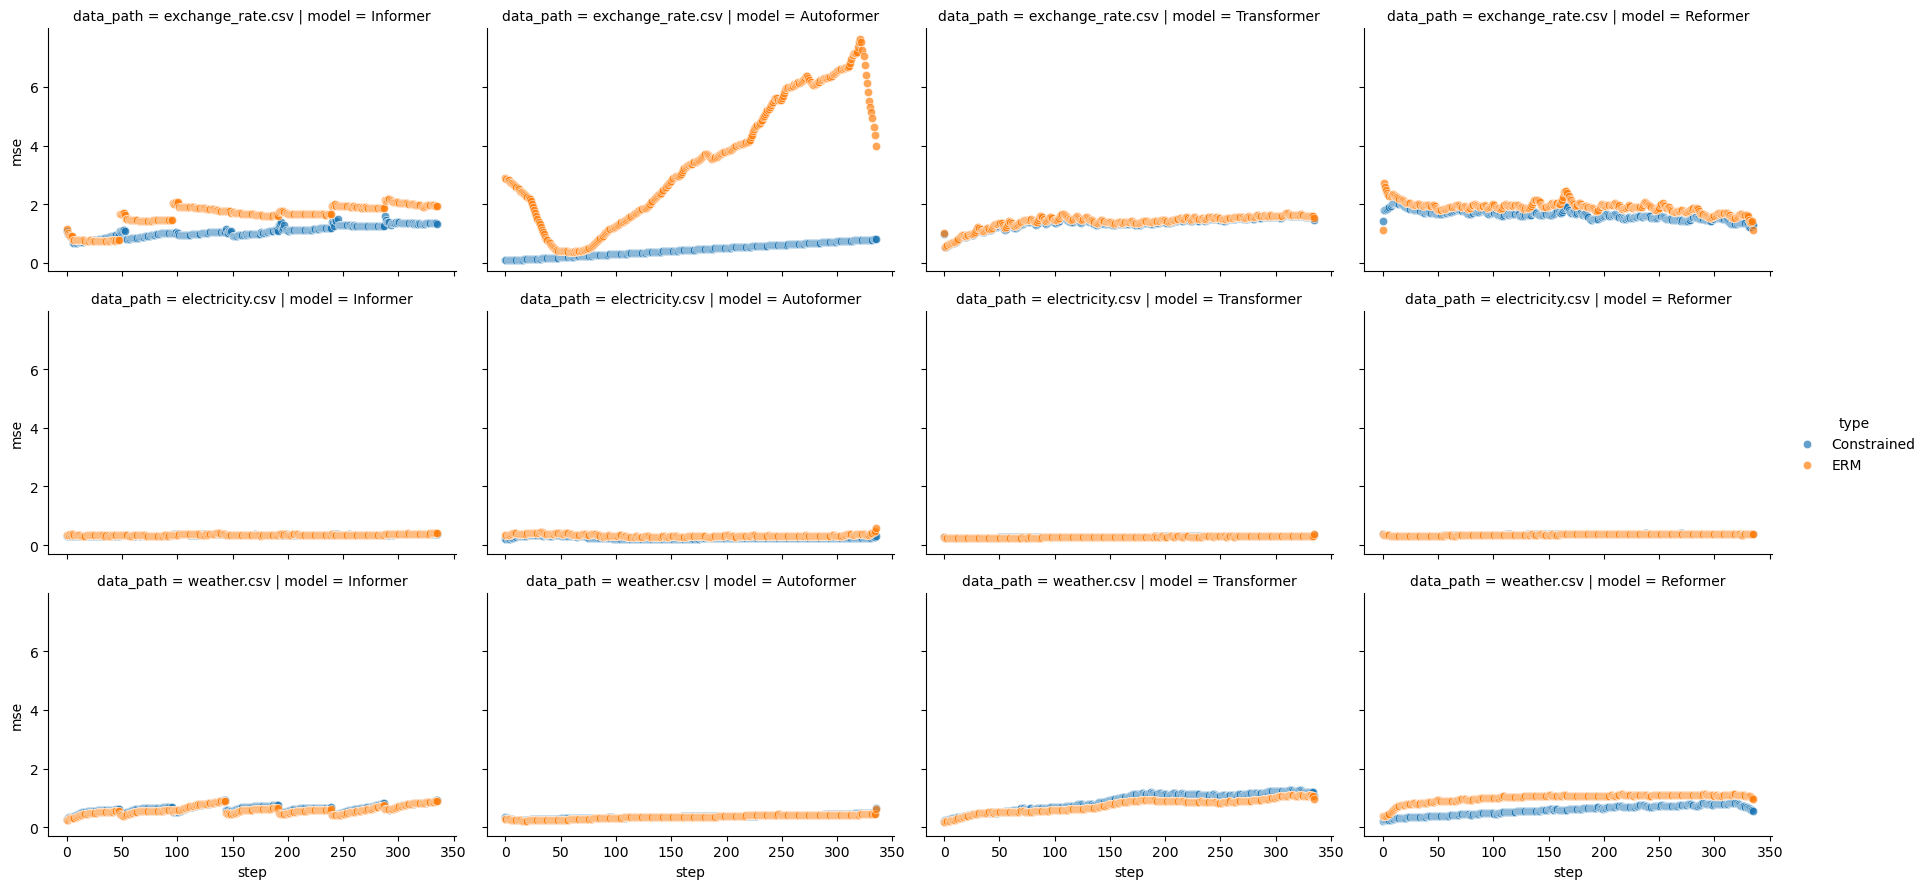

#### **ERM Vs Constrained 720 (split=test)**

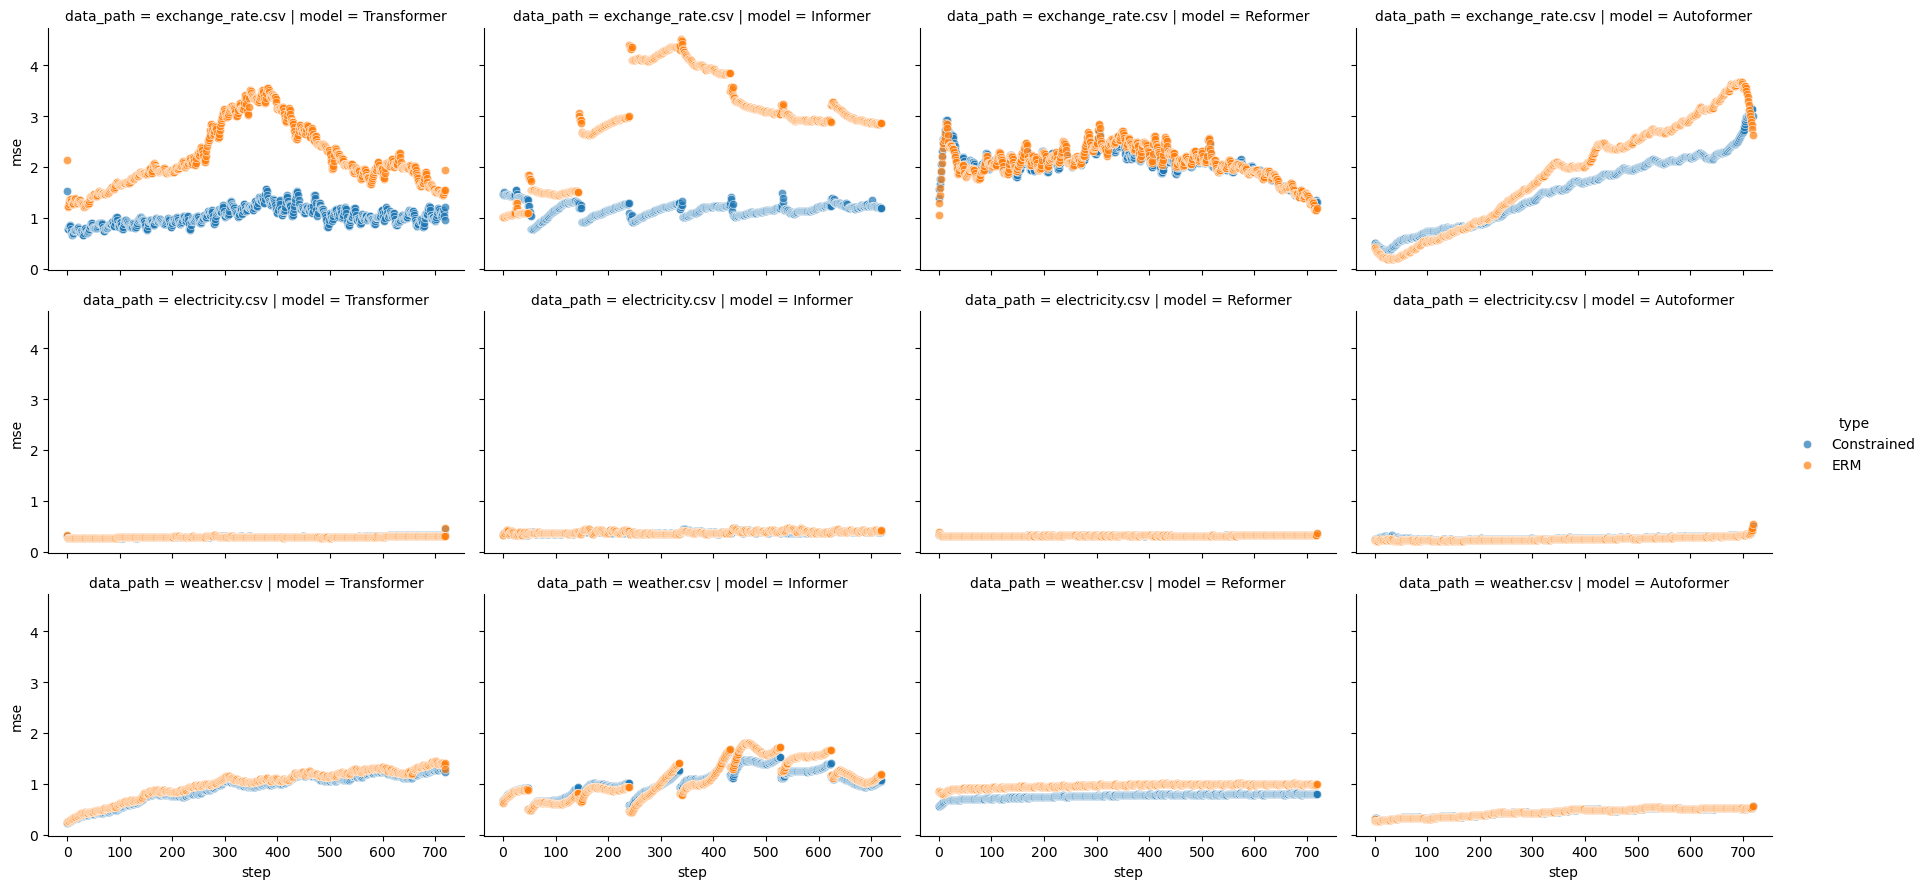

In [32]:
# PARAMS
split="test"
#constraint_idx = 1 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_pct50_and_erm = df_to_plot[(df_to_plot.seed==seed) & (df_to_plot.split==split)].copy()

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())
#PRED_LENS=[96]
for pred_len in PRED_LENS:
    # Add data for constant line
    df_current_plot = df_pct50_and_erm.query('pred_len==@pred_len').copy()
    #constraint_level = df_current_plot.constraint_level.unique()[0]
    #df_current_plot['constraint_level'] = constraint_level
    display(Markdown(f"#### **ERM Vs Constrained {pred_len} (split={split})**"))

    g = sns.FacetGrid(df_current_plot, col='model', row='data_path', hue='type', height=3, aspect=1.5, legend_out=True)
    #g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
    g.map(sns.scatterplot, "step", "mse", alpha=.7)
    g.add_legend()
    #TODO fix and uncomment
    #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
    plt.show()

### Multipliers over the window

#### **Multipliers vs loss 96 (split=train, constraint_idx=2)**

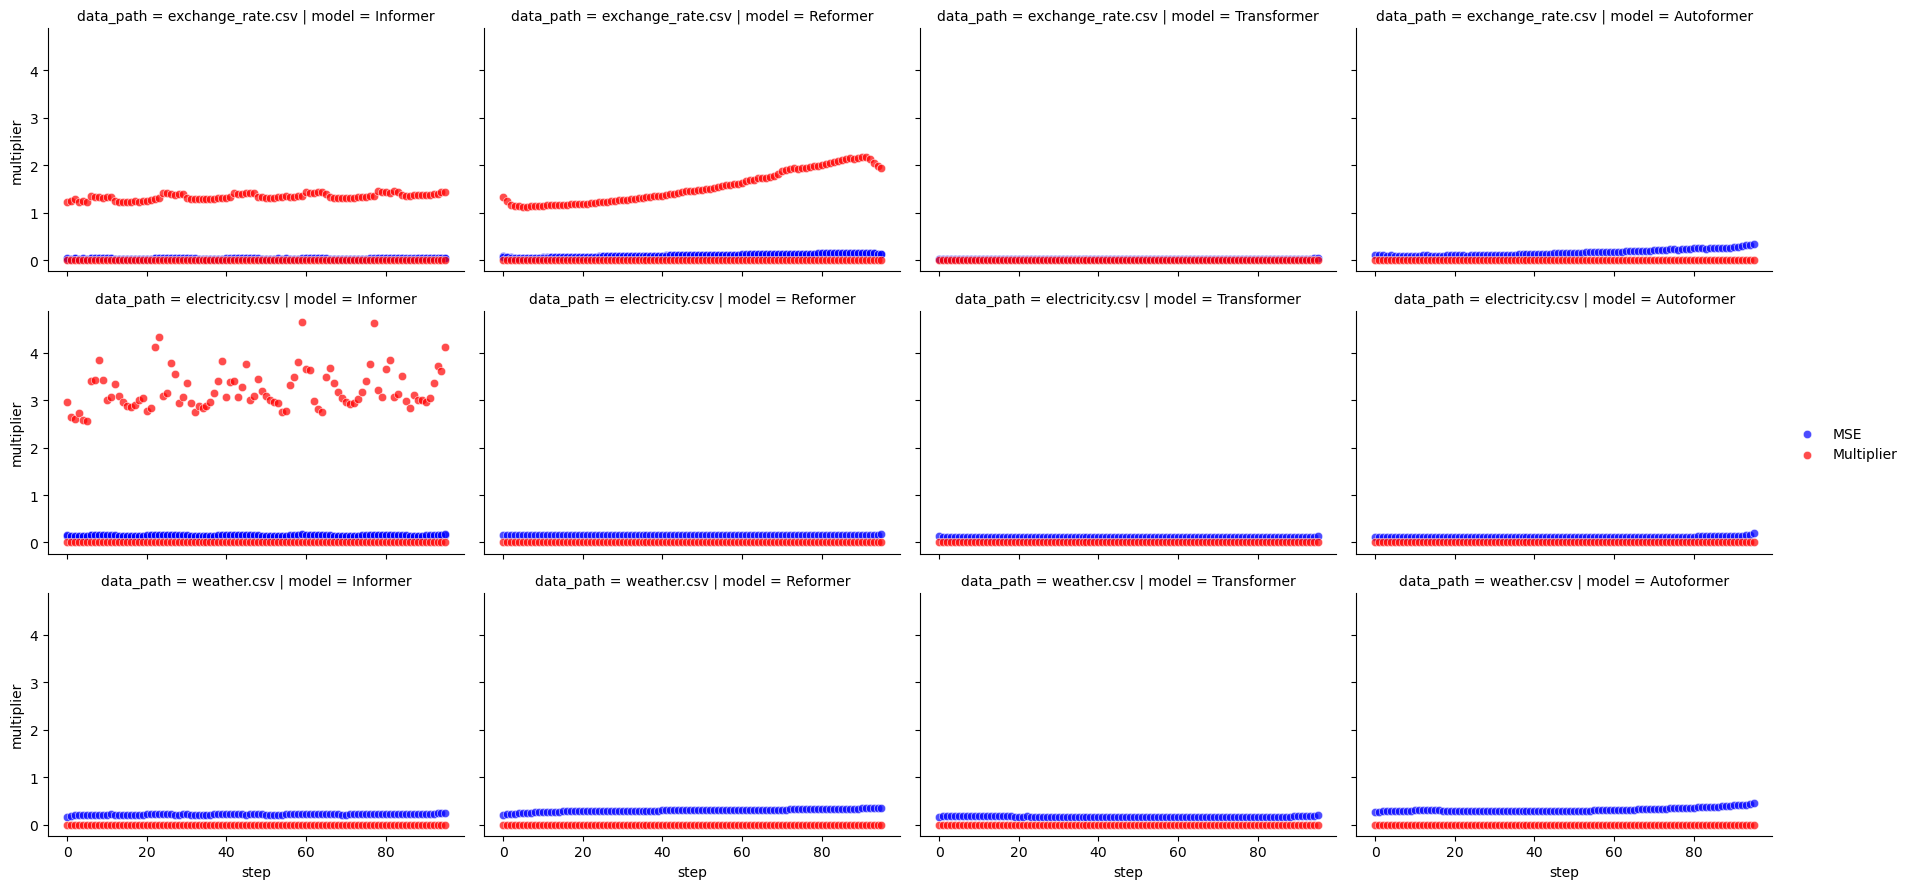

#### **Multipliers vs loss 192 (split=train, constraint_idx=2)**

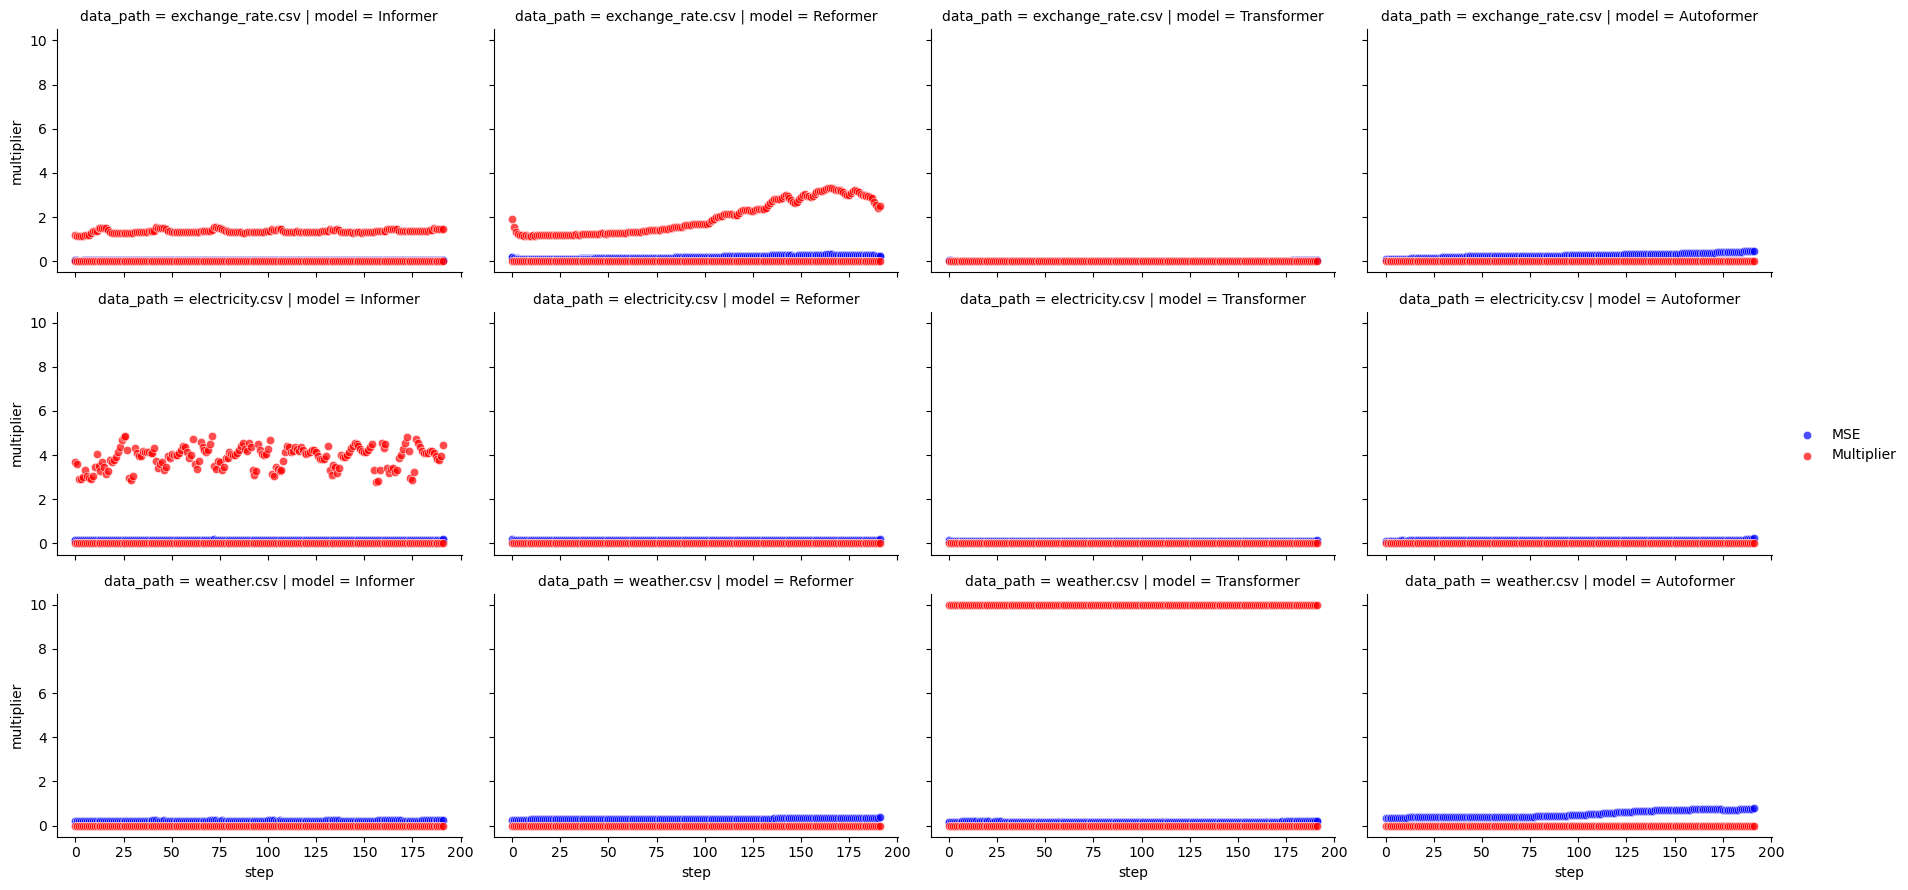

#### **Multipliers vs loss 336 (split=train, constraint_idx=2)**

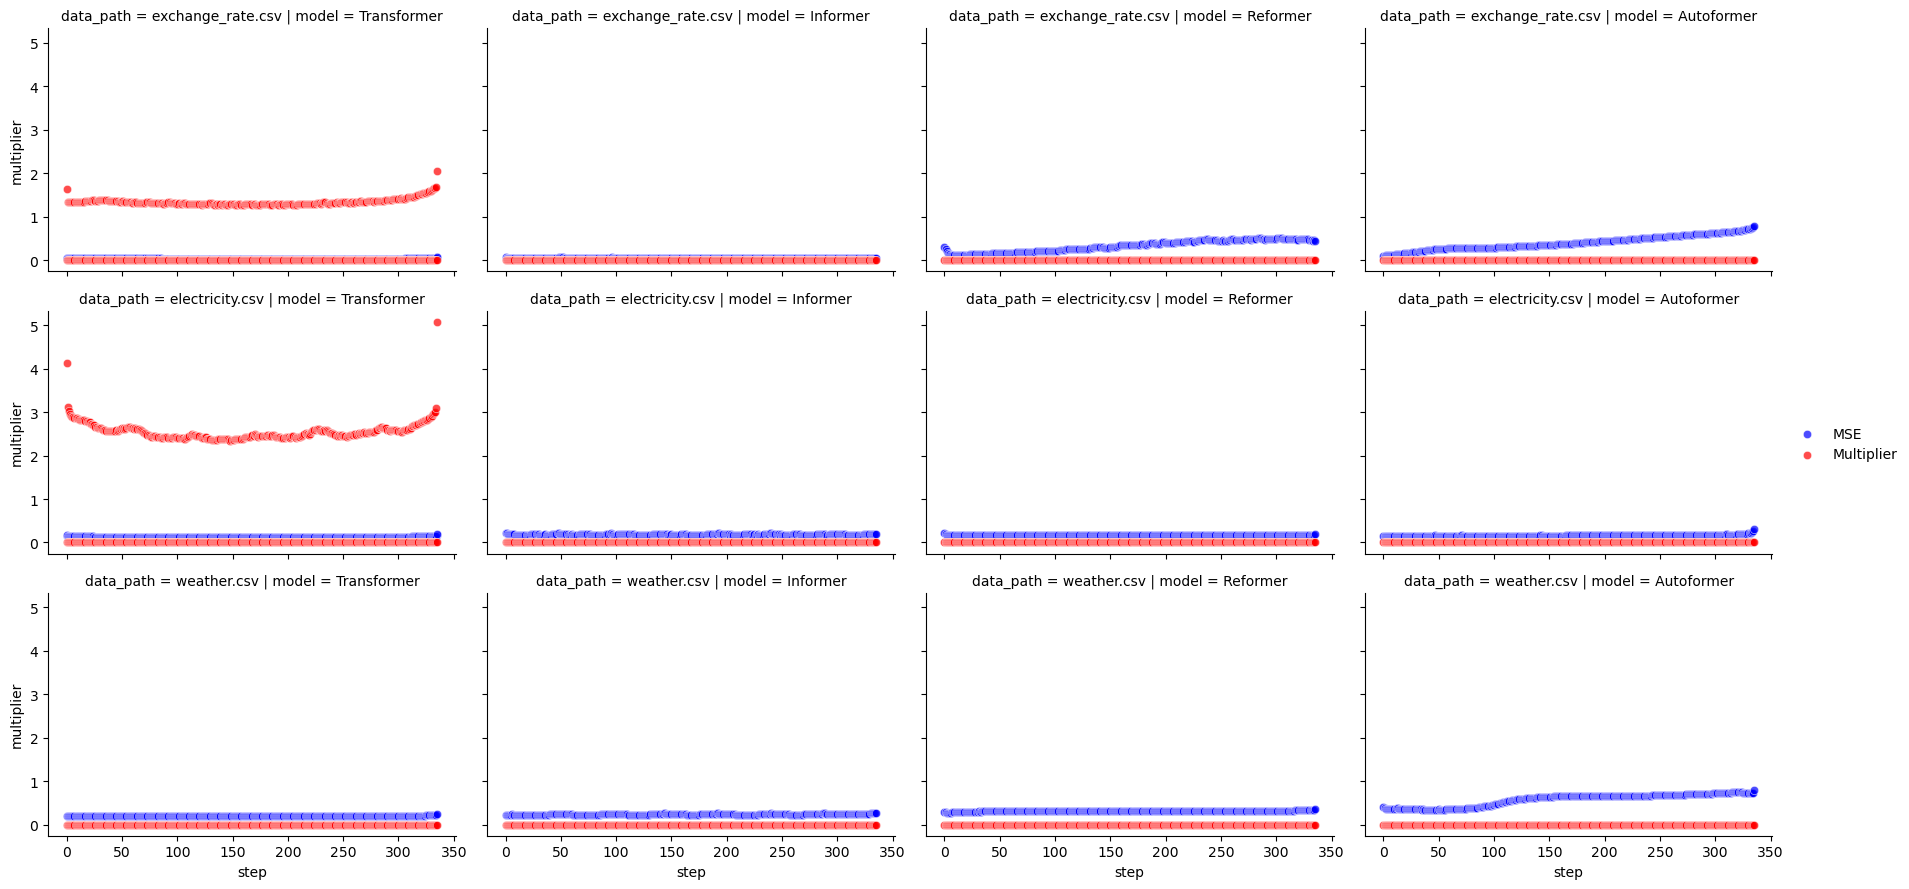

#### **Multipliers vs loss 720 (split=train, constraint_idx=2)**

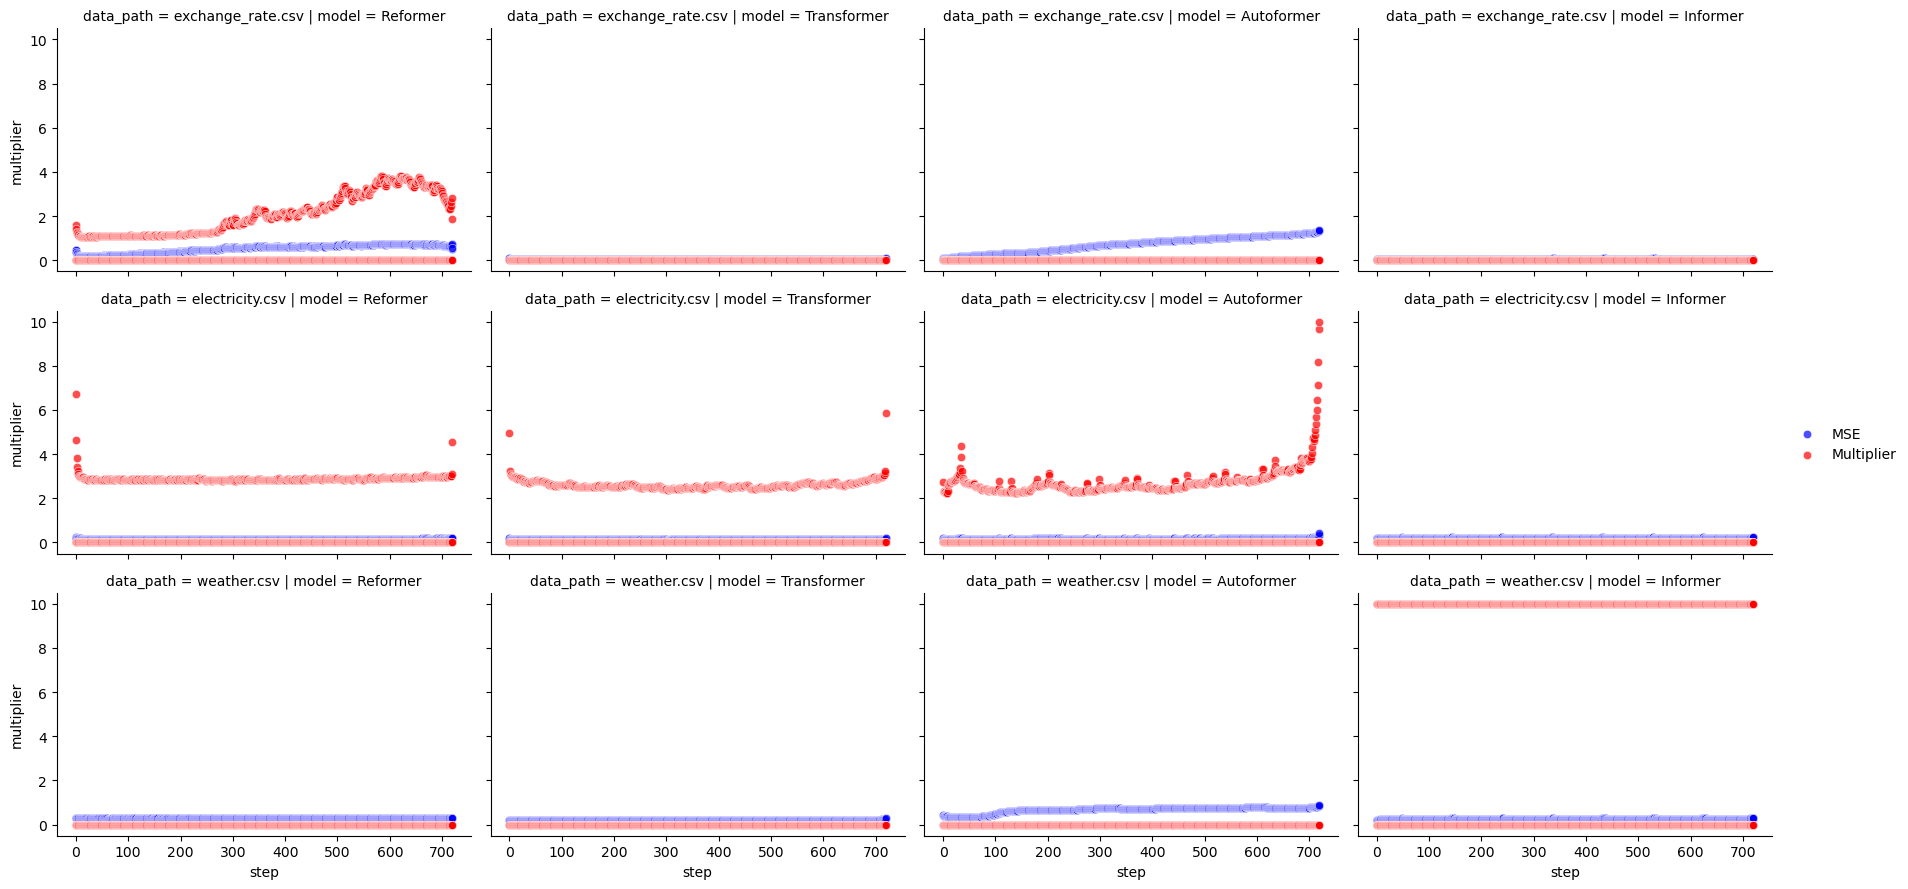

In [33]:
# PARAMS
split="train"
constraint_idx = 2 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_pct50 = df_to_plot[
    (df_to_plot.constraint_idx.isin([0,constraint_idx])) 
    & (df_to_plot.seed==seed) & (df_to_plot.split==split)
    & (df_to_plot.constraint_type=="constant")
    ].copy()

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())
#PRED_LENS=[96]
for pred_len in PRED_LENS:
    # Add data for constant line
    df_current_plot = df_pct50.query('pred_len==@pred_len').copy()
    #constraint_level = df_current_plot.constraint_level.unique()[0]
    #df_current_plot['constraint_level'] = constraint_level
    display(Markdown(f"#### **Multipliers vs loss {pred_len} (split={split}, constraint_idx={constraint_idx})**"))

    g = sns.FacetGrid(df_current_plot, col='model', row='data_path', height=3, aspect=1.5, legend_out=True)
    # Plot multipliers and MSEs
    g.map(sns.scatterplot, "step", "mse", alpha=.7,color='blue',label='MSE')
    g.map(sns.scatterplot, "step", "multiplier", alpha=.7,color='red',label='Multiplier')
    # Add legend the series

    g.add_legend()
    #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
    plt.show()

### PAPER: Singular ERM vs Constrained 
Of ERM vs constrained

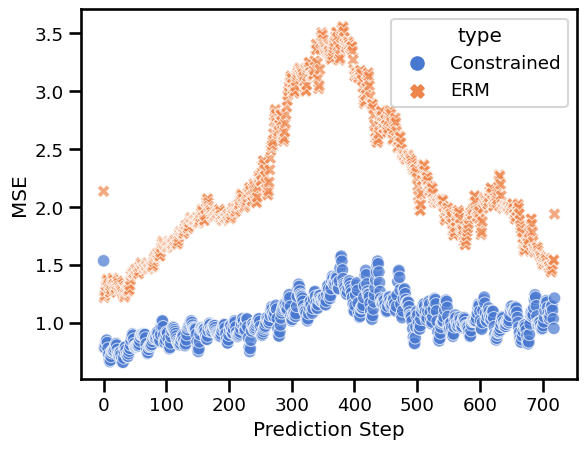

<Figure size 350x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [397]:
# #Option 1
# model="Autoformer"
# data_path="exchange_rate.csv"
# pred_len=336
# split='test'

# # Option 2
model="Transformer"
data_path="exchange_rate.csv"
pred_len=720
split='test'

# # Option 3
# model="Autoformer"
# data_path="exchange_rate.csv"
# pred_len=720
# split='test'

# # Option 4
# model="Autoformer"
# data_path="weather.csv"
# pred_len=96
# split='test'

#seaborn params
plt.rcParams['lines.linewidth'] = 1.8
sns.set_context("talk", font_scale=0.8)
#sns.set_palette(sns.cubehelix_palette())
#sns.set_palette("tab10")
sns.set_palette("muted")
#sns.set_palette("Greys")

# Filter data
to_plot = df_to_plot.query('model==@model & data_path==@data_path & pred_len==@pred_len & split==@split').copy()
to_plot.loc[to_plot.constraint_level==-1.0,'constraint_level'] = to_plot.constraint_level.max()

to_plot.rename(columns={'mse':'MSE','step': "Prediction Step"},inplace=True)
#display(to_plot.constraint_level)
g = sns.scatterplot(data=to_plot,
                    x="Prediction Step",
                    y= "MSE", 
                    alpha=.7,hue='type',style='type',
                    #palette={'ERM':'blue','Constrained':'red'},
                    legend='full')
#g.set_title(f"{model} on {data_path} (pred_len={pred_len}, split={split})")
plt.figure(figsize=(3.5, 2.6))  # Width, height in inches (standard on papers according to chatGPT)
plt.show()
plt.savefig('deleteme.pdf', bbox_inches='tight')  # For a PGF file



#g2 = sns.lineplot(data=to_plot.query("constraint_type=='constant'"),x="Prediction Step",y= "constraint_level", alpha=.7,color='green',label='Constraint Level')

### (old) ERM vs constrained

[3 2 1 0]


### Dataset: electricity.csv pred_len: 96 constraint_idx: 3

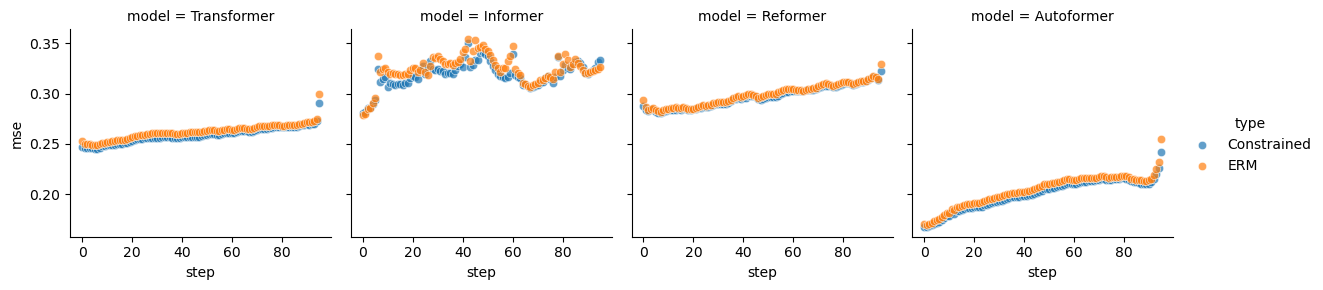

### Dataset: electricity.csv pred_len: 96 constraint_idx: 2

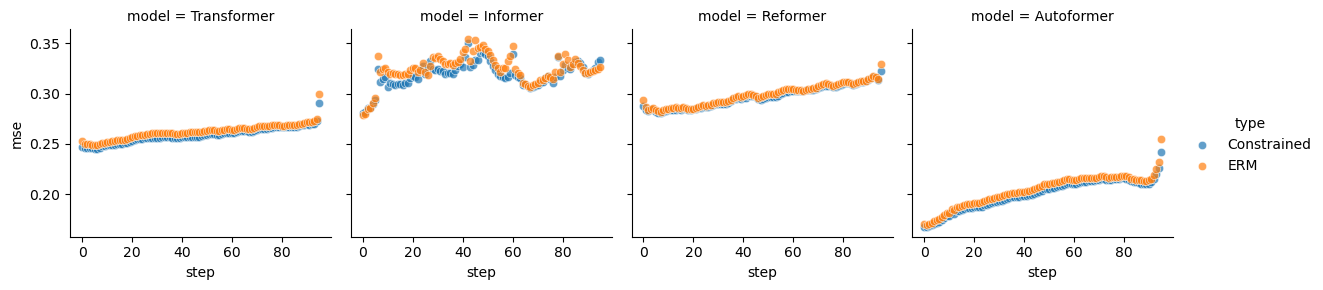

### Dataset: electricity.csv pred_len: 96 constraint_idx: 1

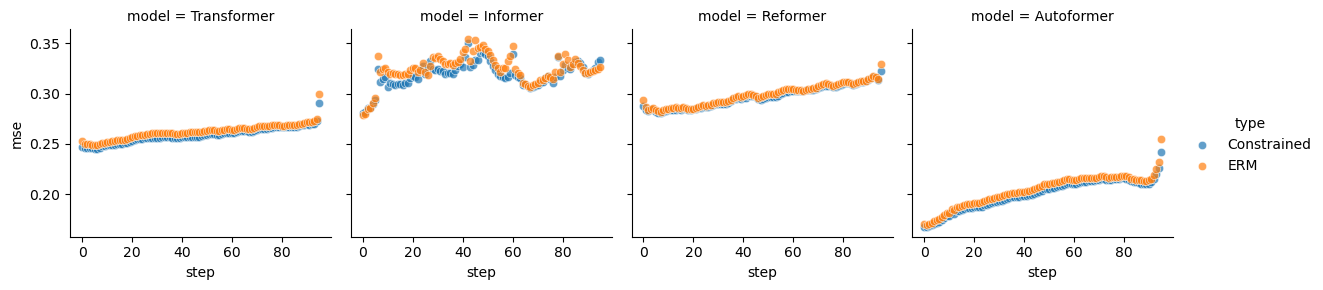

### Dataset: electricity.csv pred_len: 96 constraint_idx: 0

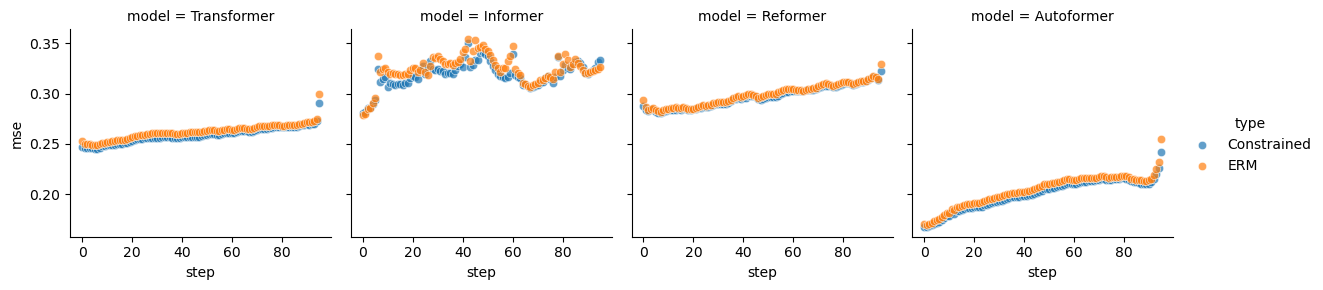

[5 6 2 1 0]


### Dataset: electricity.csv pred_len: 192 constraint_idx: 5

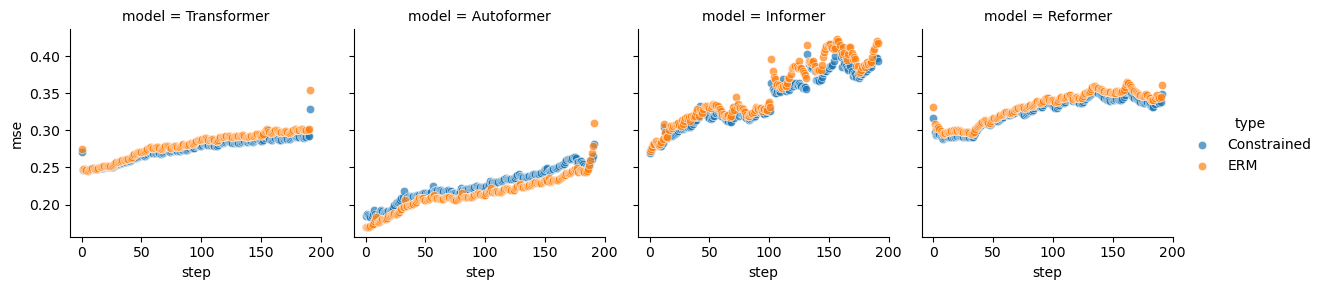

### Dataset: electricity.csv pred_len: 192 constraint_idx: 6

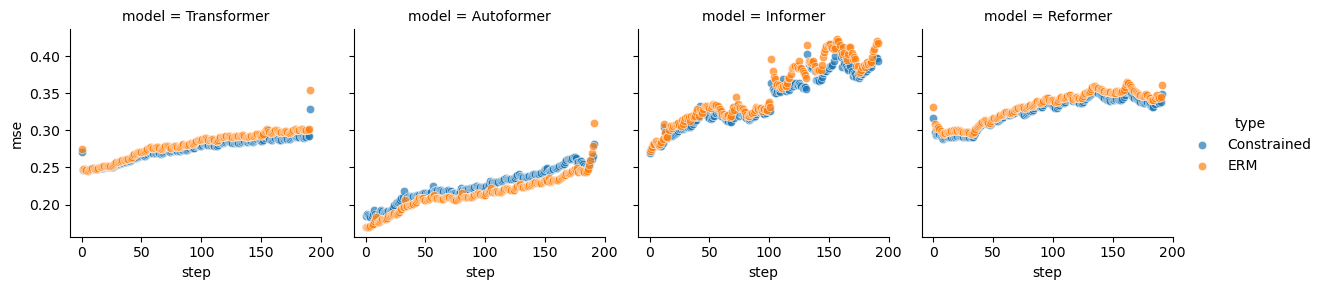

### Dataset: electricity.csv pred_len: 192 constraint_idx: 2

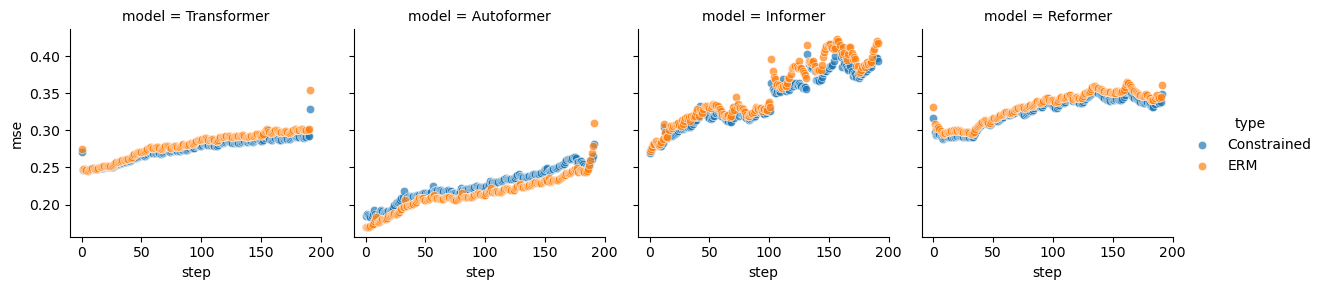

### Dataset: electricity.csv pred_len: 192 constraint_idx: 1

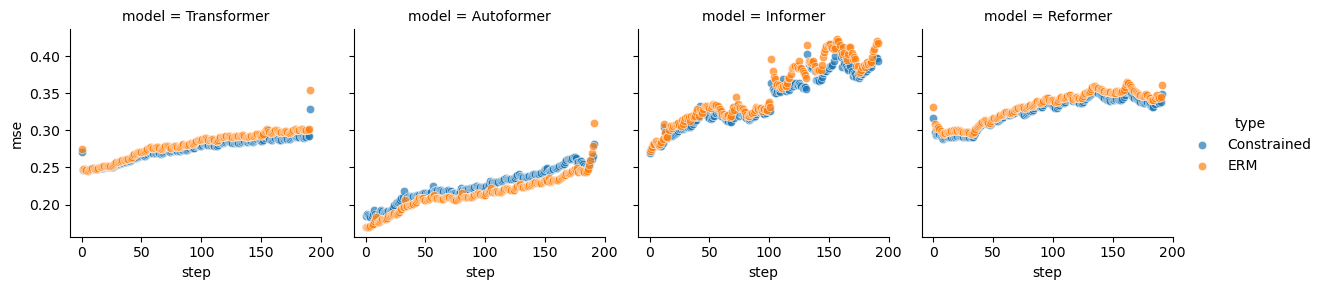

### Dataset: electricity.csv pred_len: 192 constraint_idx: 0

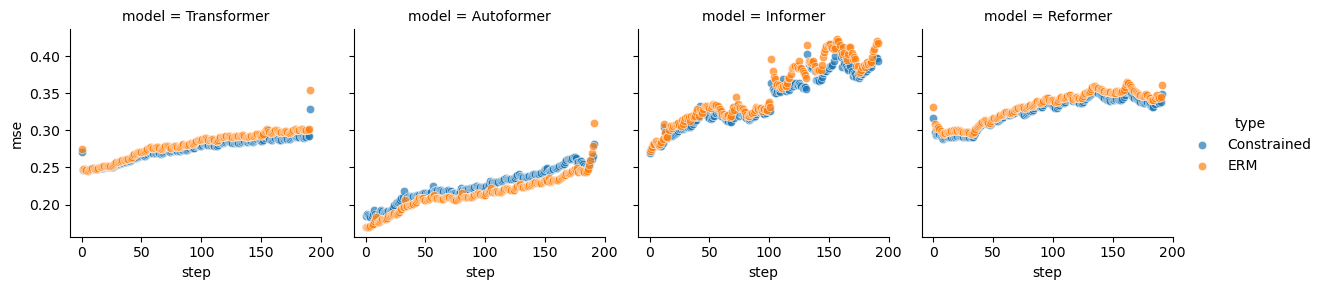

[5 2 3 0]


### Dataset: electricity.csv pred_len: 336 constraint_idx: 5

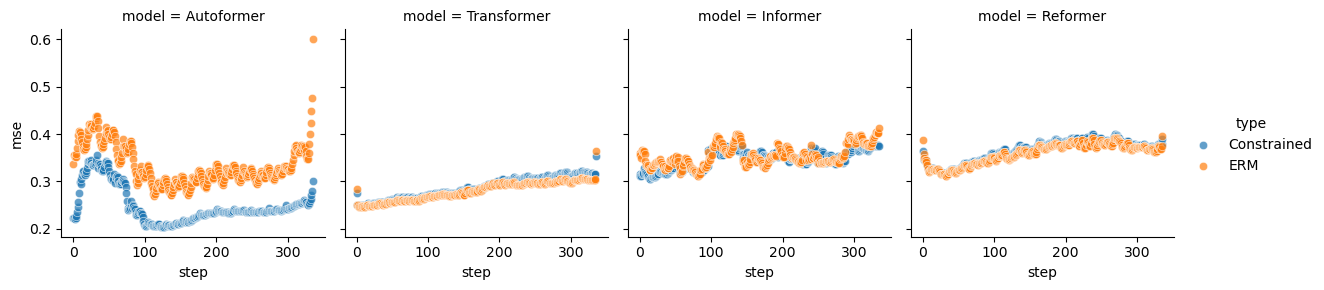

### Dataset: electricity.csv pred_len: 336 constraint_idx: 2

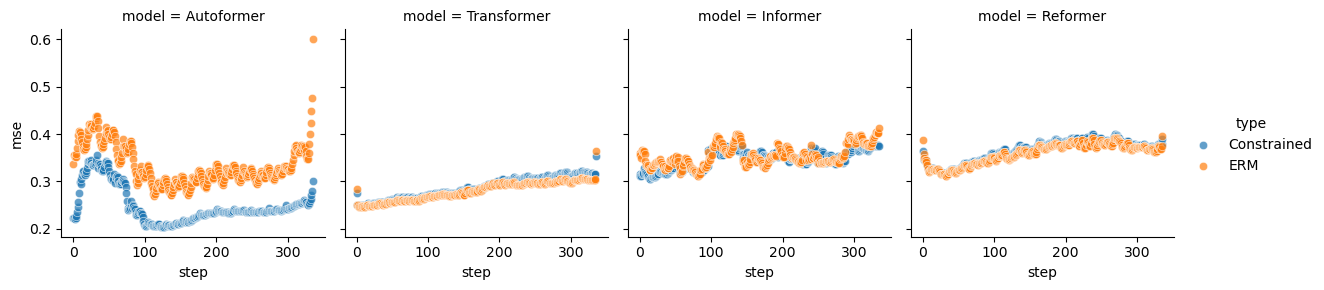

### Dataset: electricity.csv pred_len: 336 constraint_idx: 3

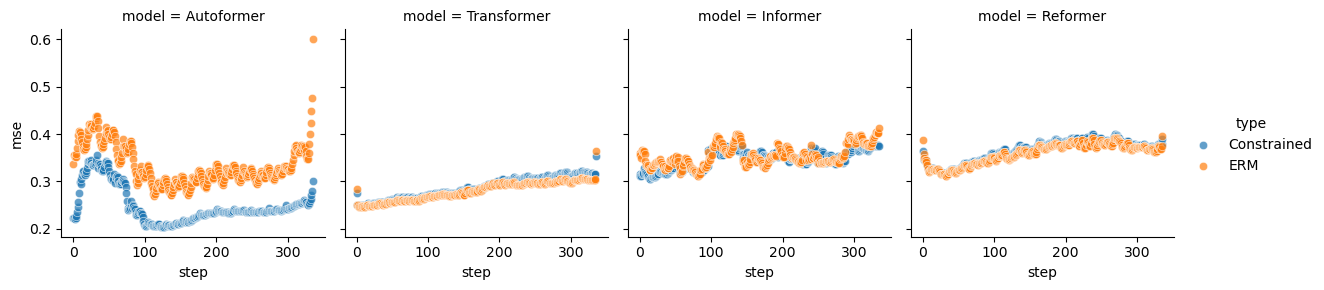

### Dataset: electricity.csv pred_len: 336 constraint_idx: 0

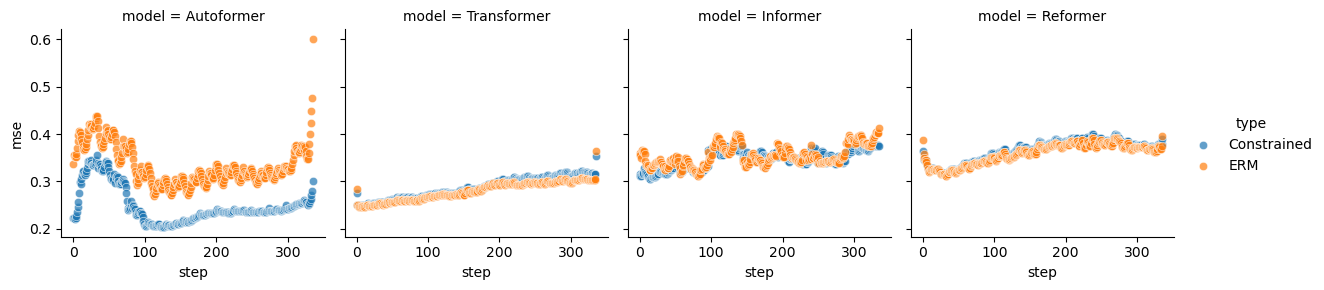

[2 3 0]


### Dataset: electricity.csv pred_len: 720 constraint_idx: 2

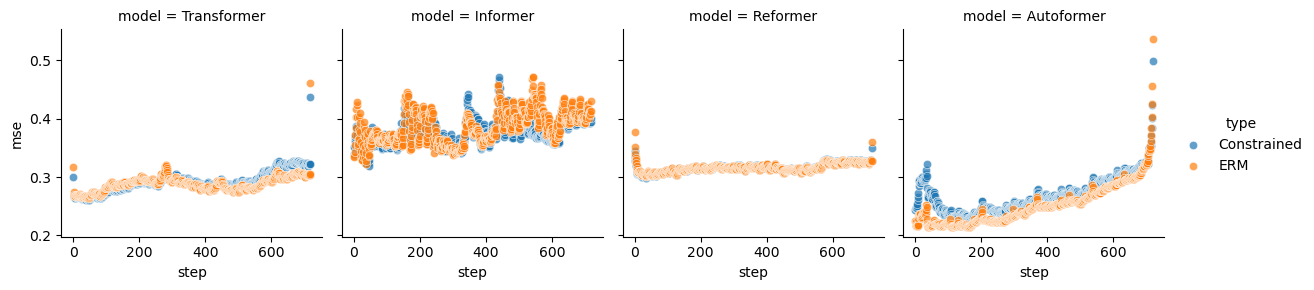

### Dataset: electricity.csv pred_len: 720 constraint_idx: 3

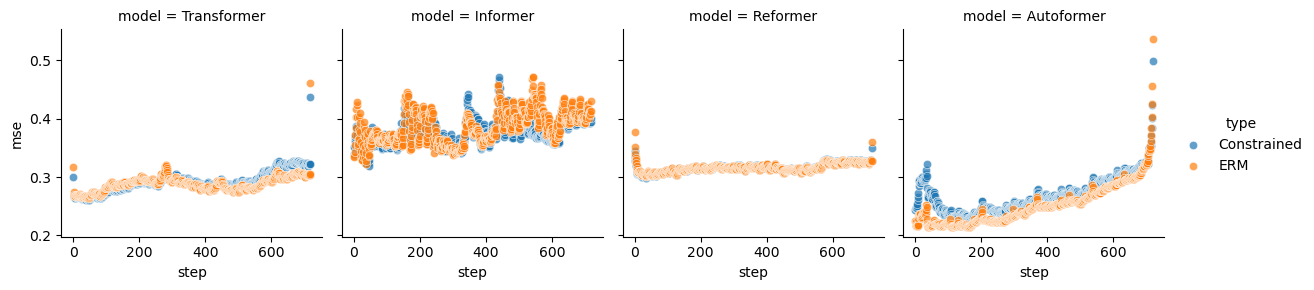

### Dataset: electricity.csv pred_len: 720 constraint_idx: 0

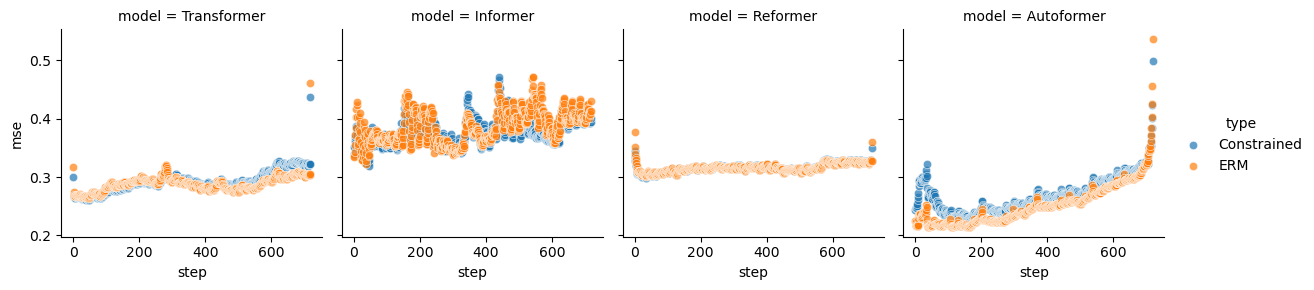

[6 2 4 0]


### Dataset: exchange_rate.csv pred_len: 96 constraint_idx: 6

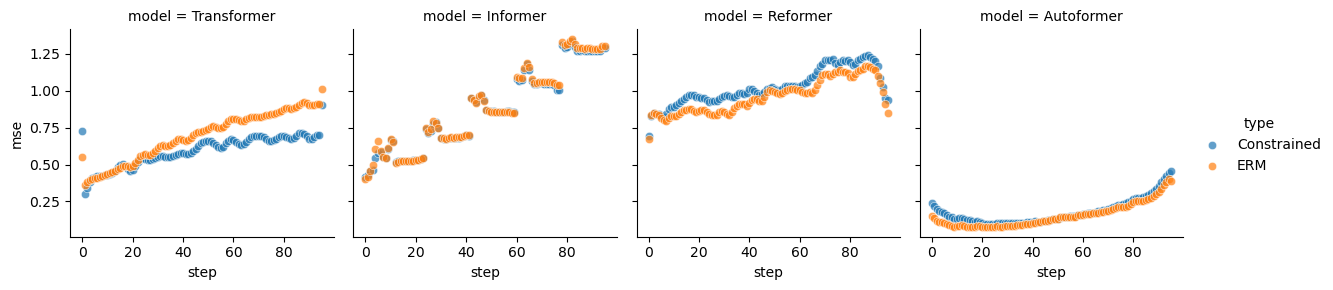

### Dataset: exchange_rate.csv pred_len: 96 constraint_idx: 2

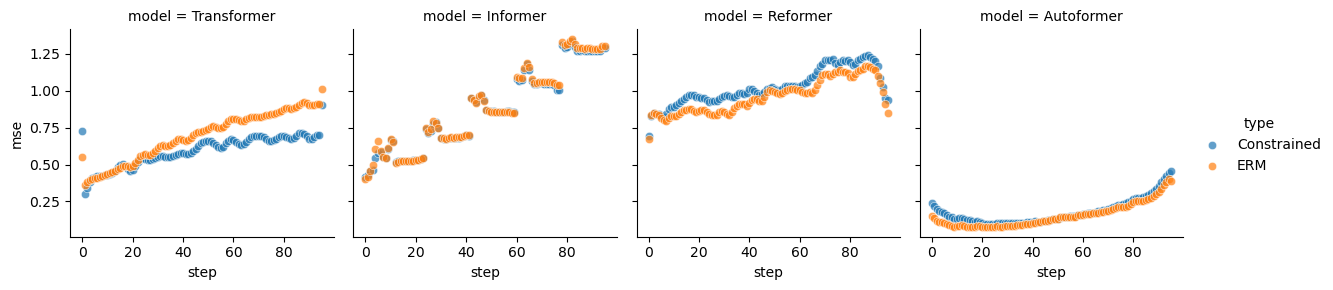

### Dataset: exchange_rate.csv pred_len: 96 constraint_idx: 4

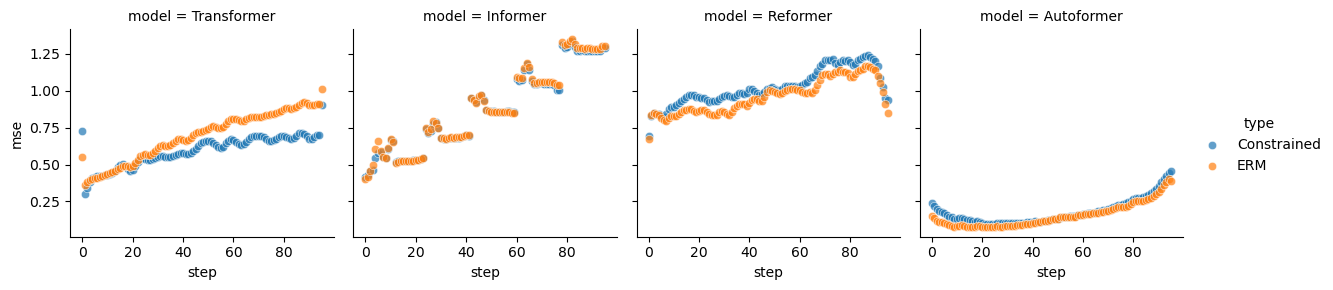

### Dataset: exchange_rate.csv pred_len: 96 constraint_idx: 0

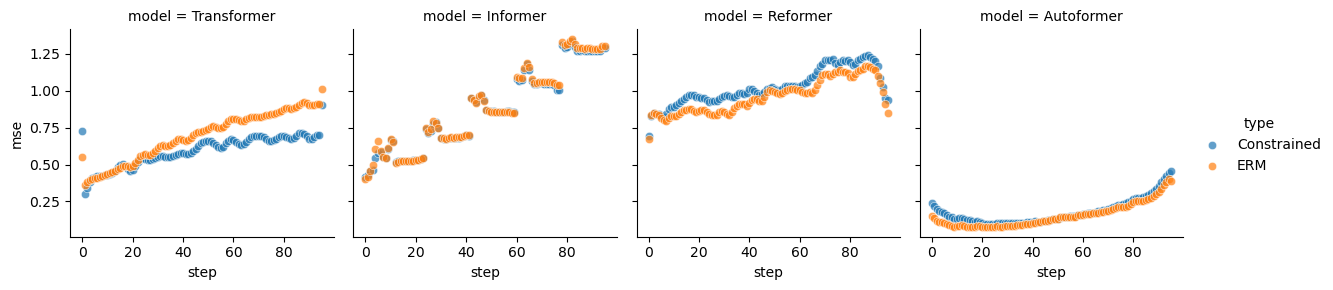

[6 3 2 0]


### Dataset: exchange_rate.csv pred_len: 192 constraint_idx: 6

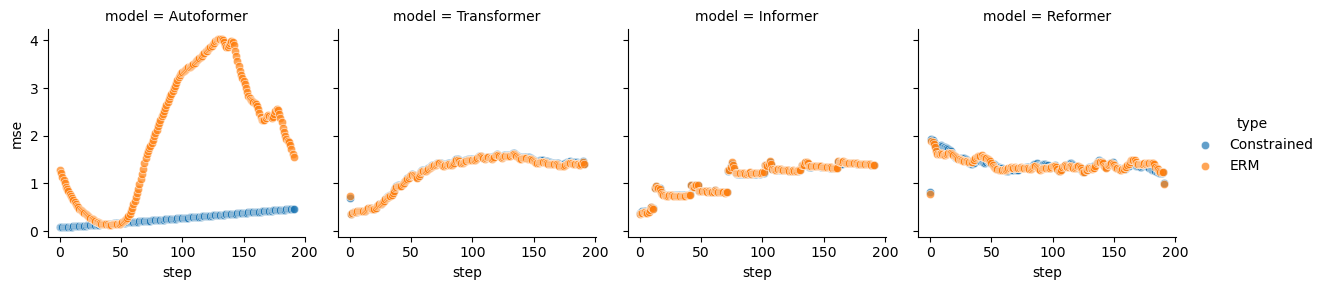

### Dataset: exchange_rate.csv pred_len: 192 constraint_idx: 3

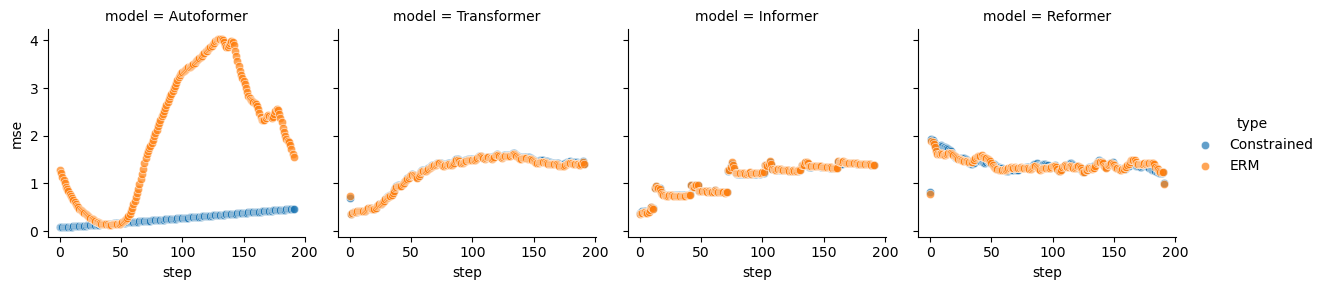

### Dataset: exchange_rate.csv pred_len: 192 constraint_idx: 2

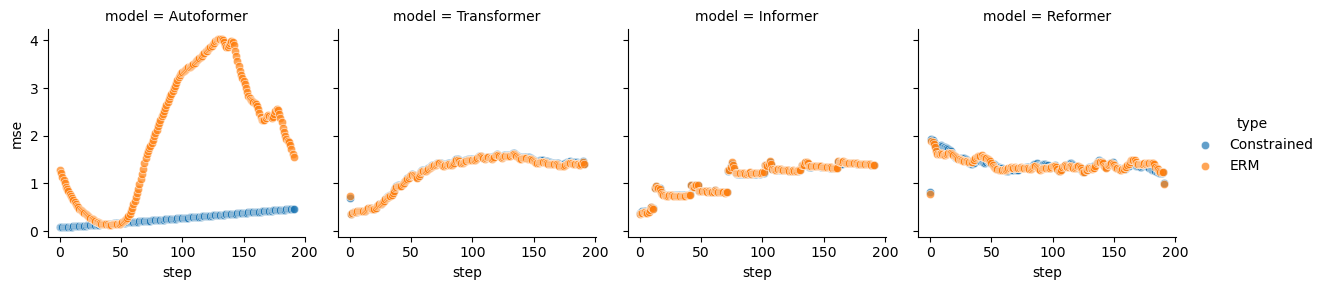

### Dataset: exchange_rate.csv pred_len: 192 constraint_idx: 0

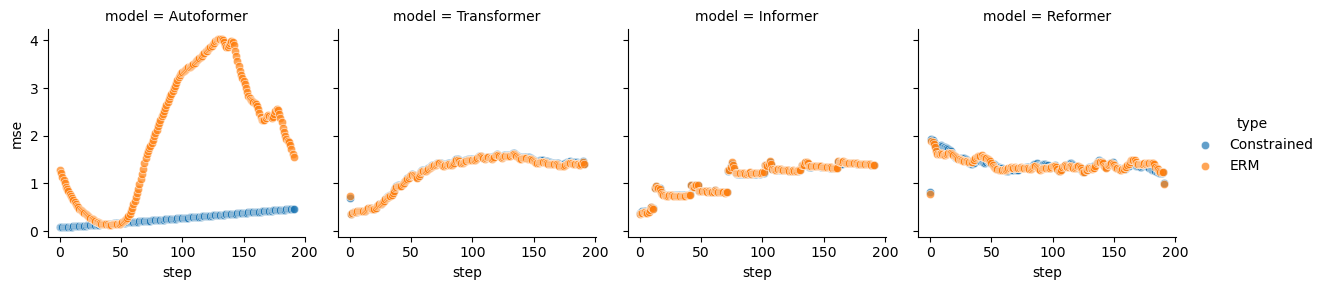

[6 2 1 0]


### Dataset: exchange_rate.csv pred_len: 336 constraint_idx: 6

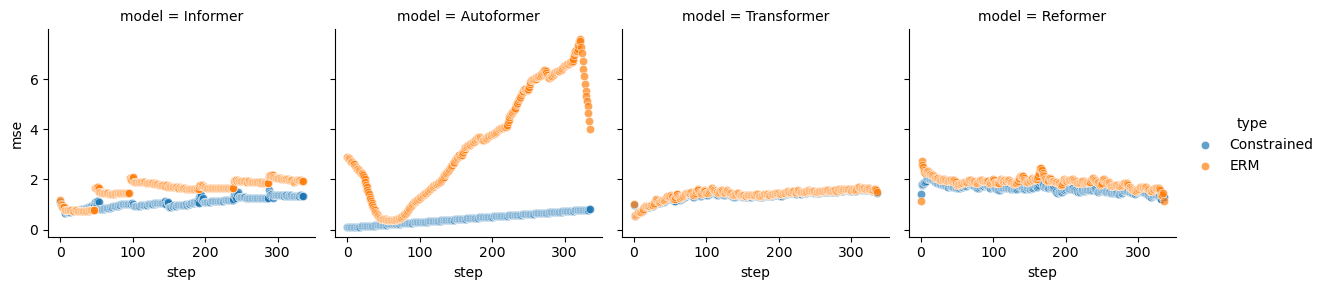

### Dataset: exchange_rate.csv pred_len: 336 constraint_idx: 2

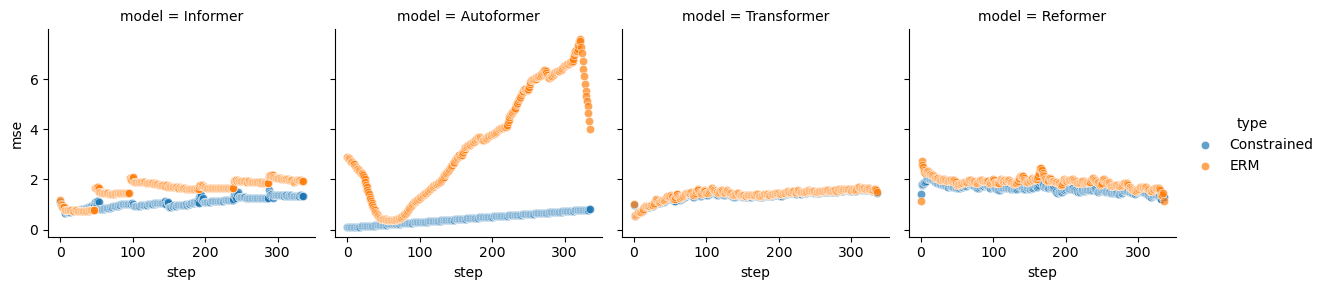

### Dataset: exchange_rate.csv pred_len: 336 constraint_idx: 1

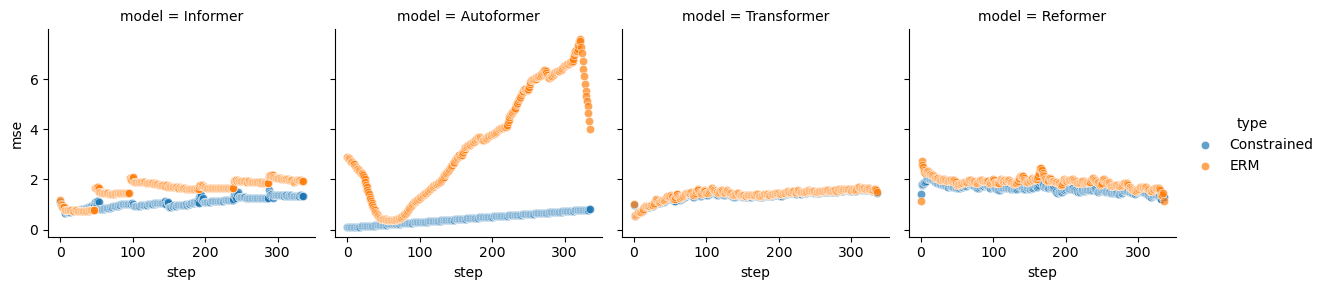

### Dataset: exchange_rate.csv pred_len: 336 constraint_idx: 0

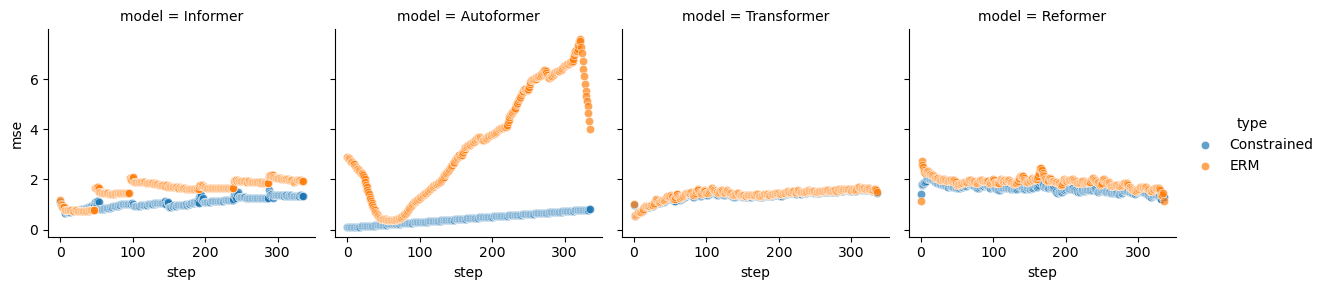

[5 2 3 0]


### Dataset: exchange_rate.csv pred_len: 720 constraint_idx: 5

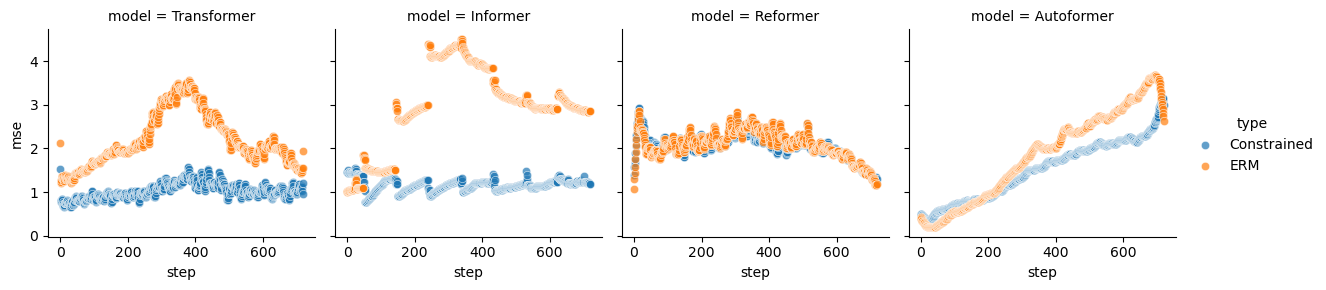

### Dataset: exchange_rate.csv pred_len: 720 constraint_idx: 2

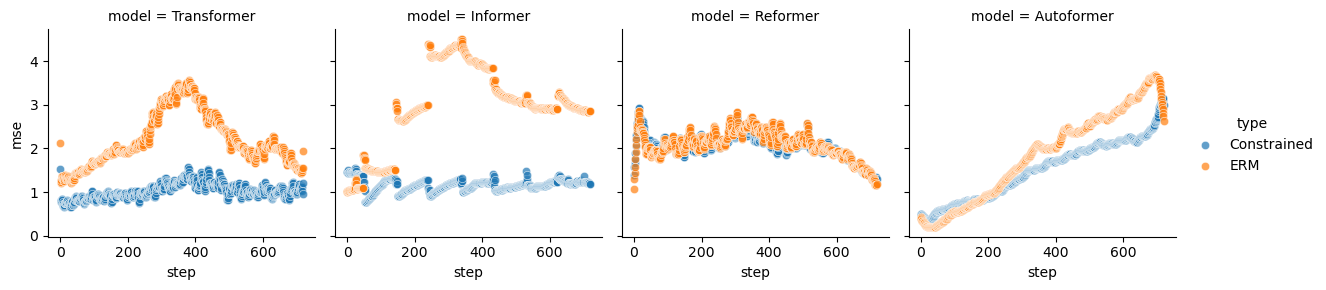

### Dataset: exchange_rate.csv pred_len: 720 constraint_idx: 3

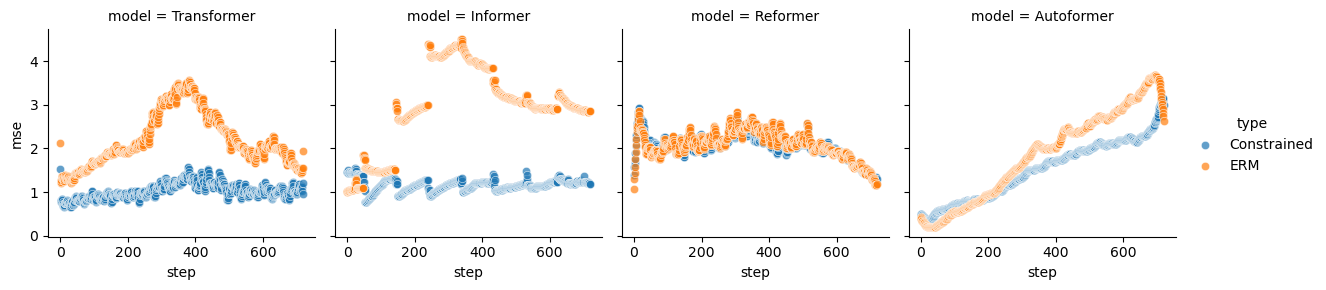

### Dataset: exchange_rate.csv pred_len: 720 constraint_idx: 0

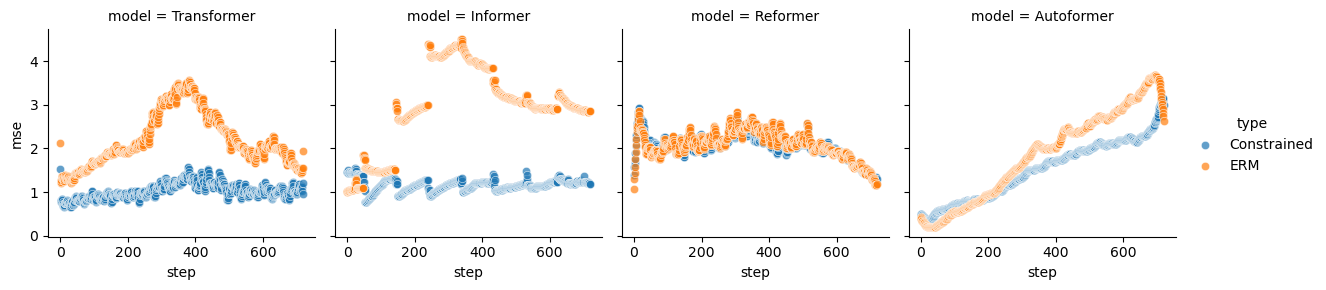

[4 6 1 0]


### Dataset: weather.csv pred_len: 96 constraint_idx: 4

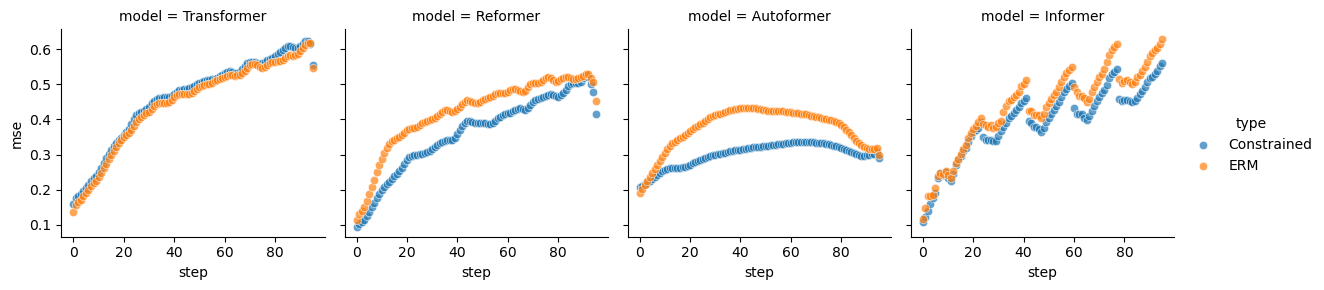

### Dataset: weather.csv pred_len: 96 constraint_idx: 6

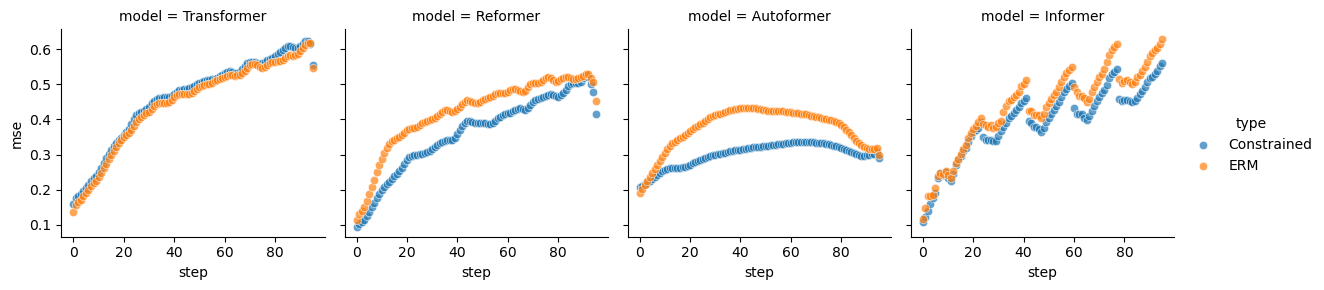

### Dataset: weather.csv pred_len: 96 constraint_idx: 1

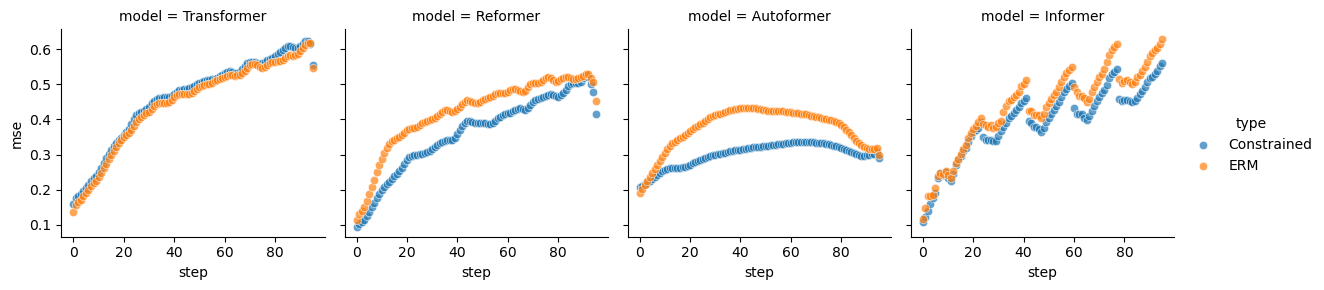

### Dataset: weather.csv pred_len: 96 constraint_idx: 0

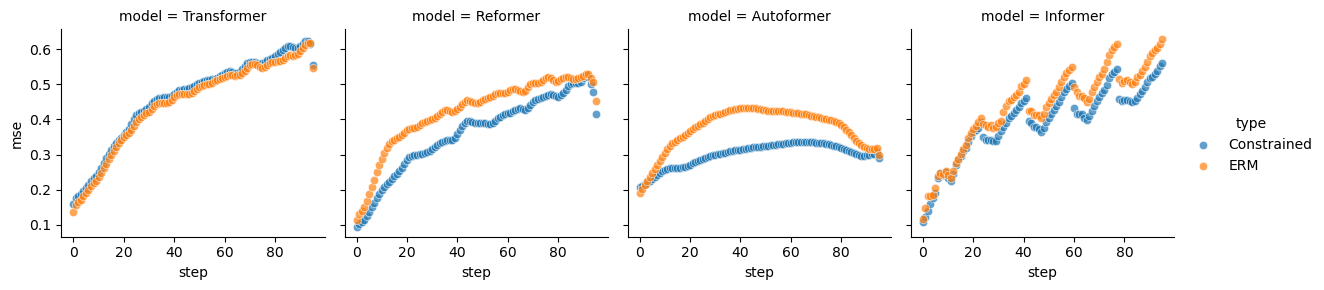

[5 4 2 1 0]


### Dataset: weather.csv pred_len: 192 constraint_idx: 5

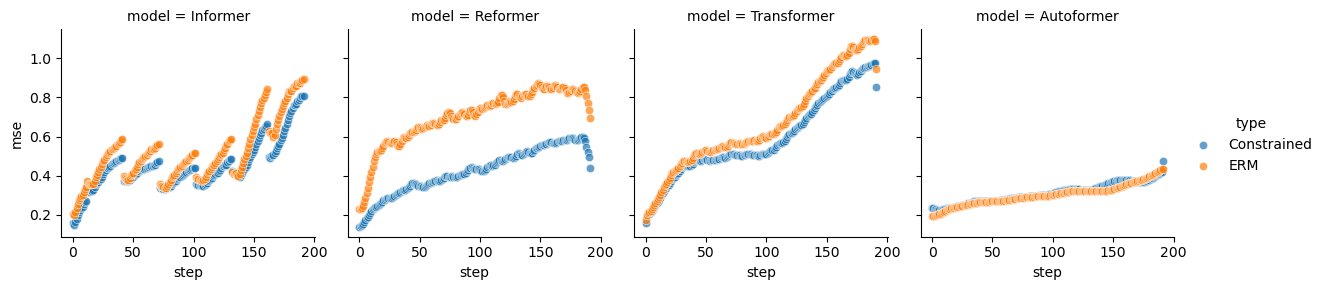

### Dataset: weather.csv pred_len: 192 constraint_idx: 4

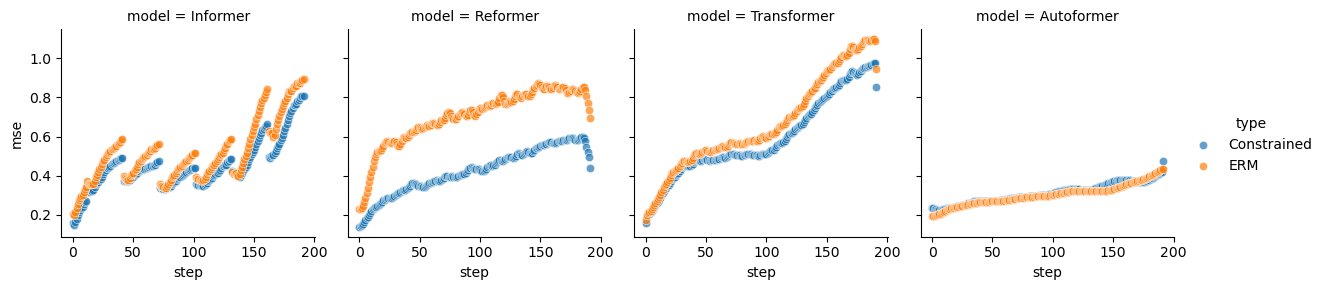

### Dataset: weather.csv pred_len: 192 constraint_idx: 2

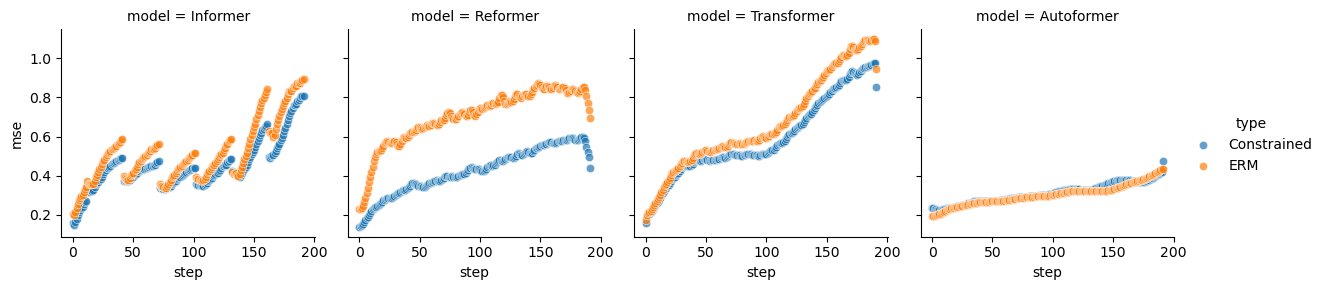

### Dataset: weather.csv pred_len: 192 constraint_idx: 1

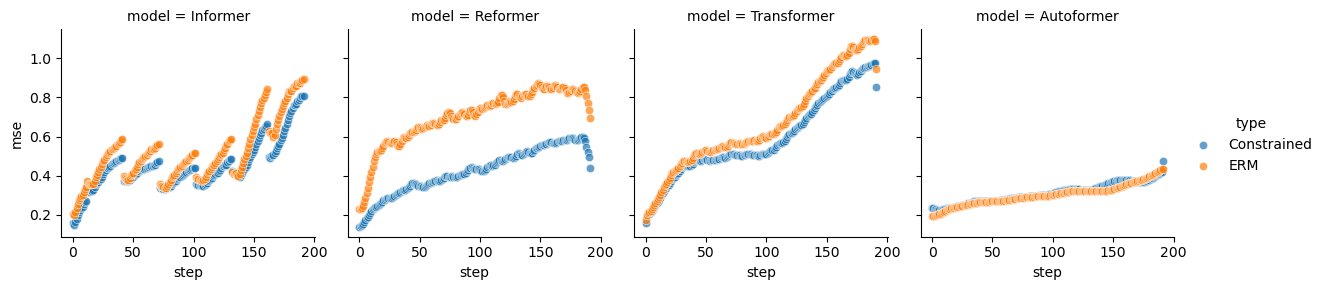

### Dataset: weather.csv pred_len: 192 constraint_idx: 0

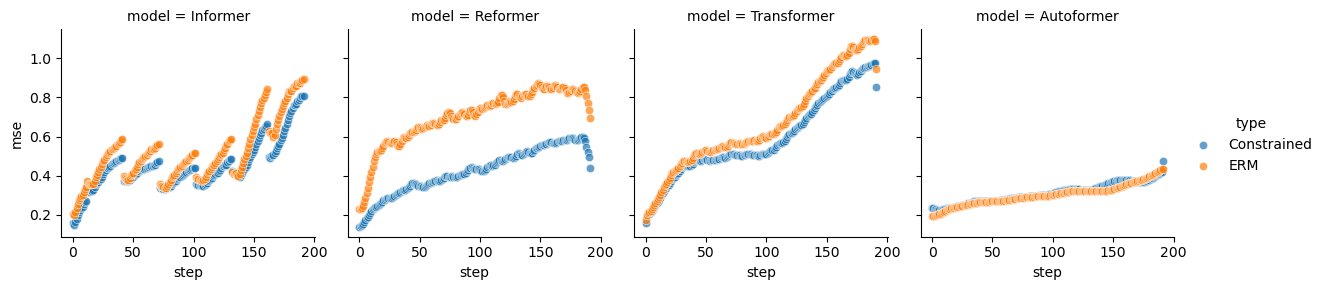

[5 4 3 1 0]


### Dataset: weather.csv pred_len: 336 constraint_idx: 5

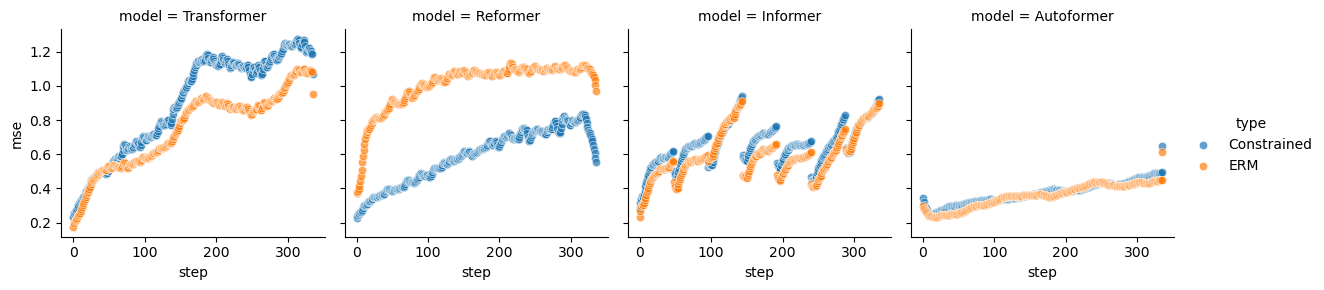

### Dataset: weather.csv pred_len: 336 constraint_idx: 4

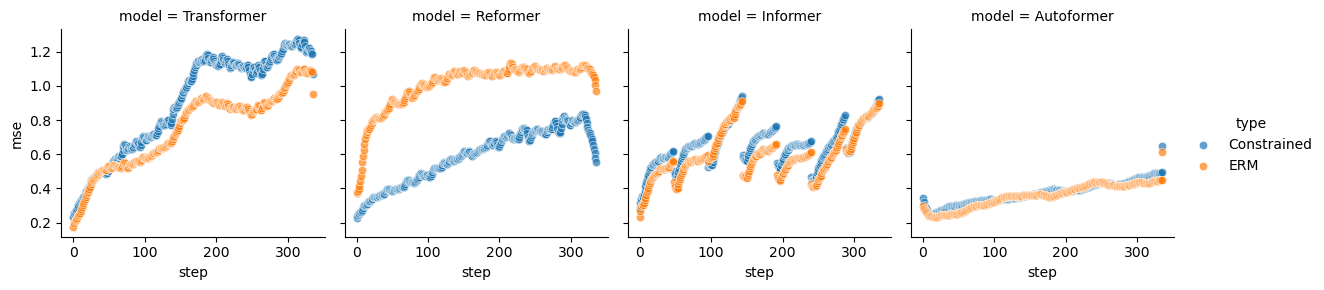

### Dataset: weather.csv pred_len: 336 constraint_idx: 3

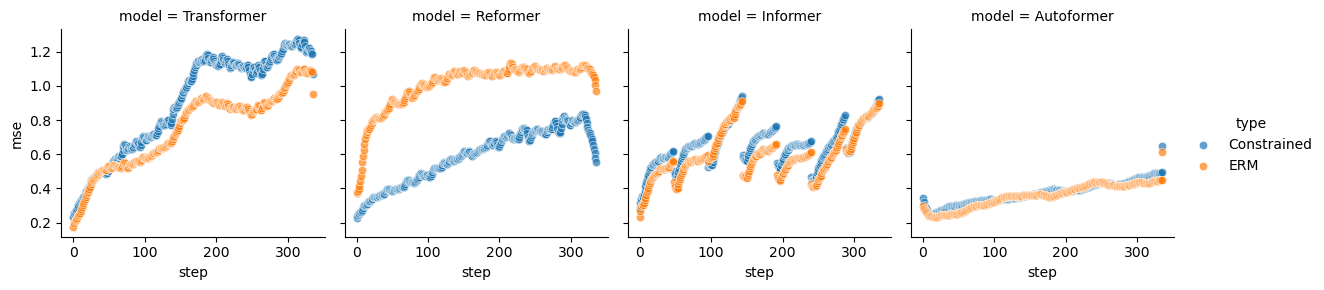

### Dataset: weather.csv pred_len: 336 constraint_idx: 1

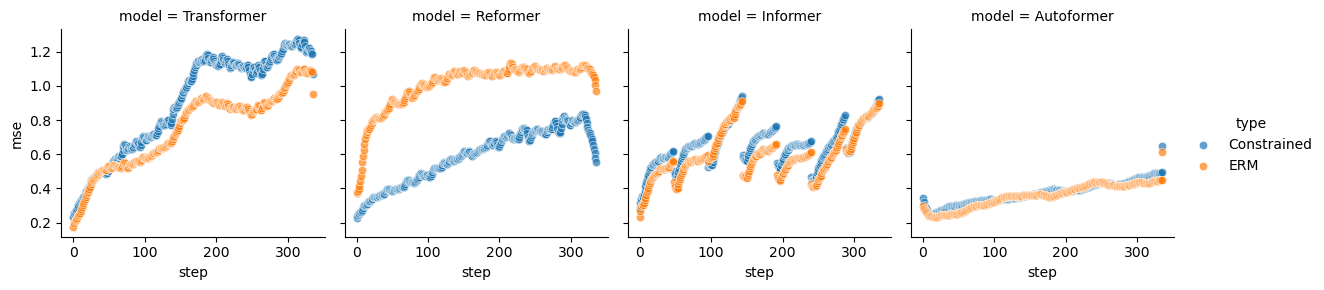

### Dataset: weather.csv pred_len: 336 constraint_idx: 0

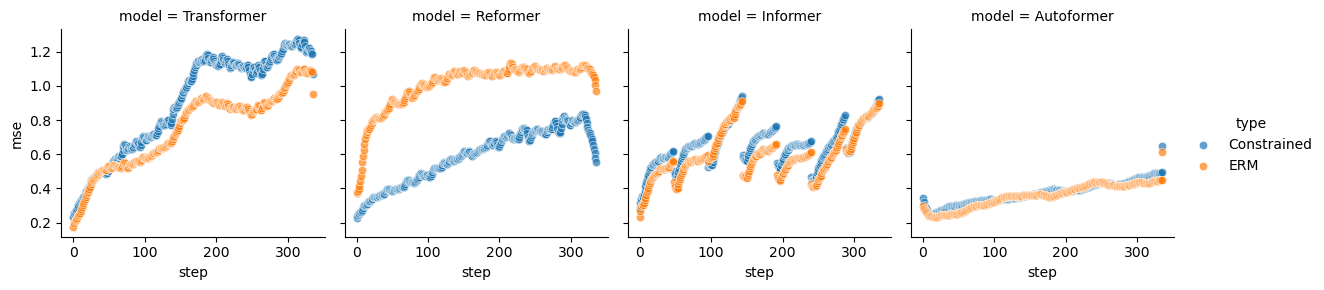

[3 2 1 0]


### Dataset: weather.csv pred_len: 720 constraint_idx: 3

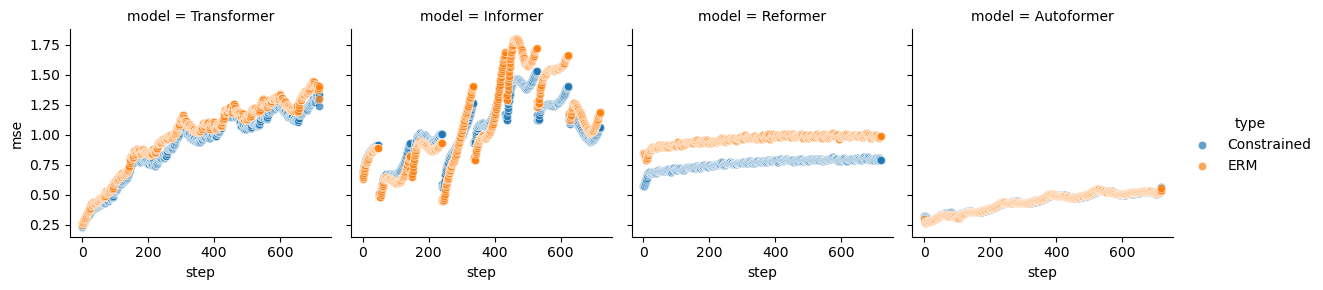

### Dataset: weather.csv pred_len: 720 constraint_idx: 2

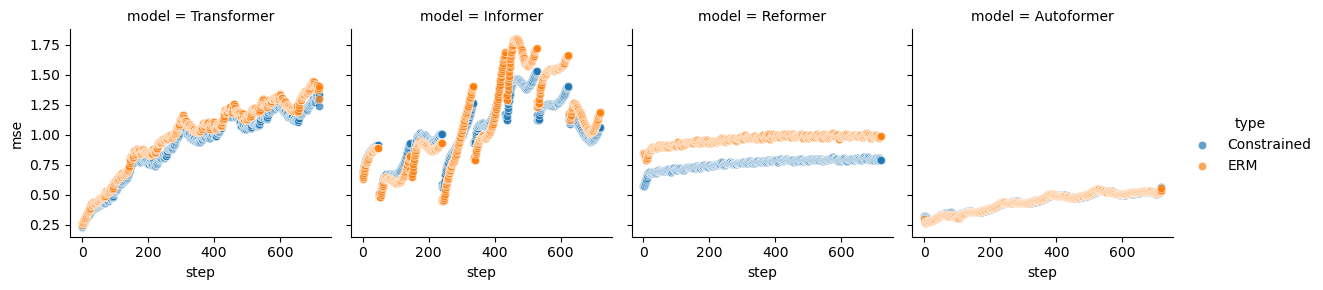

### Dataset: weather.csv pred_len: 720 constraint_idx: 1

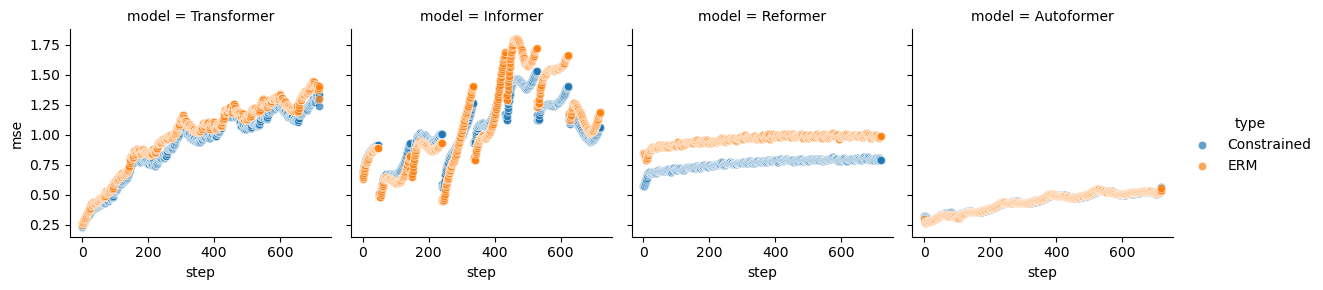

### Dataset: weather.csv pred_len: 720 constraint_idx: 0

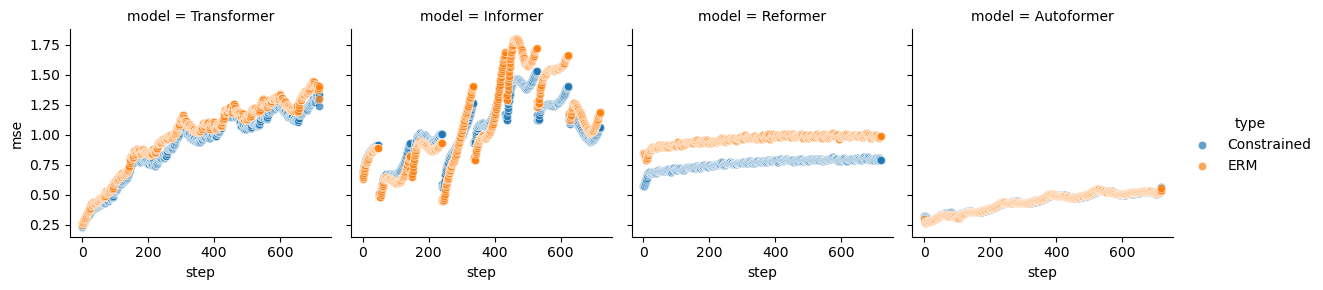

In [353]:
from IPython.display import display, Markdown
to_plot = df_to_plot[(df_to_plot.split=='test')].copy()
for (data_path,pred_len), series in to_plot.groupby(['data_path',"pred_len"]):
    constraints = series.constraint_idx.unique()
    print(constraints)
    constraints = constraints[constraints!=-1] # to iterate over all constraints explored.
    for constraint_idx in constraints:
        display(Markdown(f"### Dataset: {data_path} pred_len: {pred_len} constraint_idx: {constraint_idx}"))
        plot_series = series#series[series["constraint_idx"]==constraint_idx]
        
        #means_per_experiment = plot_series.groupby(['pred_len','constraint_level','Algorithm','model','epoch','type'])['mse'].mean().reset_index()
        #display(means_per_experiment)
        # do a pivot where model are the rows, and the columns constrained and unconstrained
        #display(means_per_experiment.pivot(index=['model'], columns='type', values='mse').reset_index())

        # sns.scatterplot(x="step", y="mse", hue="Algorithm",style="split", data=plot_series)
        
        # plt.axhline(y=constraint_level, color='r', linestyle='-')
        # plt.title(f"Pred Length: {pred_len}, Constraint_level: {constraint_level}")
        # plt.show()

        # This same scatterplot but in a grid by algorithm. 
        g = sns.FacetGrid(plot_series, col="model", hue="type")
        g.map(sns.scatterplot, "step", "mse", alpha=.7)
        g.add_legend()
        # add the hline
        # for ax in g.axes:
        #     ax.axhline(y=constraint_level, color='r', linestyle='-')
        plt.show()
        # export this plot to latex. Remove the dot in constraint_level decimal
        #TODO fix
        #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{data_path.replace('.','')}_{pred_len}_{str(constraint_level).replace('.','')}.png")
        # Fix [Errno 2] No such file or directory: 'figures/electricity.csv_96_0.17_individual.png'


### ERM on multiple algorithms
As a front page chart to illustrate the problem

In [ ]:
#TODO ( I think Nacho already did this)

### Loss shaping single instance qualitative analysis

### Plotting dual variables

In [35]:
df_to_plot[['run_id','pred_len','constraint_level','data_path','model','type']].drop_duplicates().query("data_path=='weather.csv' and model=='Reformer' and type=='Constrained'")

run_id  pred_len  constraint_level    data_path     model  \
131904  ja5qqrwj       336             0.730  weather.csv  Reformer   
134064  dv2s5qjf       192             0.598  weather.csv  Reformer   
134928  dpn9jz5a        96             0.527  weather.csv  Reformer   
258768  dthgwiaz       720             0.283  weather.csv  Reformer   

               type  
131904  Constrained  
134064  Constrained  
134928  Constrained  
258768  Constrained

In [ ]:
# #df_to_plot.query('split=="train" and pred_len==96').run_id.head(1)
# #mult_cols = [f"multiplier/{i}" for i in range(0,96)]
# # Plot for every constraint level in the 96 pred len window
# #for pred_len in df_to_plot.pred_len.unique():
# display(Markdown(f"# Multipliers for window of {pred_len}"))
# # sns.scatterplot(x="step", y="multiplier", hue="model",style="constraint_level", 
# #     data=df_to_plot.query(f"split=='train' and type=='Constrained' and pred_len=={96} and data_path=='weather.csv'"))
# # same plot, but grid with one plot per model
# dd = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='train'")#.query(f"split=='train' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")
# dd_test = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='test'")#.query(f"split=='test' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")

# #print(dd_test.constraint_level.unique())
# test_set_plus_multipliers = dd[['step','multiplier']].merge(dd_test[['step','split','mse']],on='step')

# unioned = pd.concat([dd[['step','split','multiplier','mse']],test_set_plus_multipliers[['step','split','multiplier','mse']]])

# display(unioned)


# display(test_set_plus_multipliers)

# #constraint_level==0.553
# # mult on x, mse@train and mse@test on y. hue=split
# # Add step over every point
# sns.scatterplot(unioned,x="multiplier", y="mse",hue='split', alpha=.3,legend='full')



# g = sns.FacetGrid(dd, col="model", row="constraint_level")
# g.map(sns.scatterplot, "step", "multiplier", alpha=.3)
# #g.map(sns.scatterplot, "step", "mse", alpha=.3)

# Multipliers for window of 720

step  split  multiplier       mse
16128        0  train    2.801533  0.209369
16129        1  train    1.050123  0.204042
16130        2  train    0.269966  0.194581
16131        3  train    0.000000  0.189056
16132        4  train    0.000000  0.187635
...        ...    ...         ...       ...
17418235   719   test         NaN  1.910884
17418236   719   test         NaN  1.910884
17418237   719    val         NaN  1.909591
17418238   719    val         NaN  1.909591
17418239   719    val         NaN  1.909591

[17515008 rows x 4 columns]

step  multiplier  split       mse
0            0    2.801533  train  0.209369
1            0    2.801533   test  0.268508
2            0    2.801533    val  0.266284
3            0    2.801533  train  0.215619
4            0    2.801533   test  0.247226
...        ...         ...    ...       ...
17418235   719         NaN   test  1.910884
17418236   719         NaN   test  1.910884
17418237   719         NaN    val  1.909591
17418238   719         NaN    val  1.909591
17418239   719         NaN    val  1.909591

[17418240 rows x 4 columns]

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fedbc19fa70> (for post_execute):


KeyboardInterrupt: 

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fedbc19f4d0> (for post_execute):


KeyboardInterrupt: 

### More random explorations
Ideas: 
1. Loss over time
2. Infeasibility rate over time
3. Loss shape across epochs (see how it evolves)
4. Plotting dual variables

## Result tables
1. Reproduce the pivot table from notebook 11, perhaps add standard deviation reports.
2. Explore and find other interesting table visualziation

### Pivot tables (summary)

In [409]:
def style_pivot_table_best_per_params(pivoted_df):
    pivoted_df=pivoted_df.copy()
    pivoted_df.columns.names = ['metric','type','model']
    mask = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
    for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
        mask.loc[:,subset.columns] = subset.eq(subset.min(axis=1), axis=0)
        
    ##STYLE
    # truncate to 4 decimals for display
    pivoted_df=pivoted_df.style.format("{:.4f}")
    pivoted_df=pivoted_df.apply(lambda s: ['font-weight: bold;text-decoration: underline' if v else '' for v in mask.loc[s.name]], axis=1)
    return pivoted_df

def data_path_renaming(x):
    if x=="exchange_rate.csv":
        x='Exchange'
    x=x.replace(".csv","")
    if x=="electricity":
        x="ECL"
    else: 
        x=x.replace(".csv","").replace("_"," ").title()
    return latex_scaffolding_dataset(x)
def latex_scaffolding_dataset(x):
    # Add rotatebox
    x=r'\rotatebox'+'{90}{'+x+'}'
    x=r'\multirow{4}{*}{'+x+'}'
    return x
def text_bf(x):
    return r'\textbf{'+x+'}'
def latex_style_best(pivoted_df):#TODO broken
    pivoted_df=pivoted_df.copy()
    pivoted_df.columns.names = ['metric','type','model']
    mask = pd.DataFrame(False, index=pivoted_df.index, columns=pivoted_df.columns)
    for keys,subset in  pivoted_df.groupby(level=['metric','model'],axis=1):
        mask.loc[:,subset.columns] = subset.eq(subset.min(axis=1), axis=0)
    #if mask is true, add text_bf
    pivoted_df=pivoted_df.apply(lambda s: [text_bf(v) if v else '' for v in mask.loc[s.name]], axis=1)
    return pivoted_df


pd.set_option('display.max_columns', None)
def compute_pivot_over_metric(summary_metrics,pivot_value_columns=['window_std'],split='test'):
    pivoted_tables=[]
    data_paths=summary_metrics.data_path.unique()
    for data_path in data_paths:
        tp2=summary_metrics.query(f'data_path==@data_path and split==@split').copy()

        #GROUPING TEH VALS
        grouped_values=tp2.groupby(['pred_len','model','type'])[[
            'mse',
            'mcv',
            'std_mse',
            'std_mcv',
            'mean_infeasible_rate',
            'std_infeasible_rate',
            'window_std'
            ]].mean().reset_index()
        
        # Pivot of models versus constrained and ERM, values are mse and mse_diff
        all_results = grouped_values
        
        # Pivot all results, sort ascending by pred_len, then mean_violation on constrained
        pivoted=all_results.pivot(
            index=['pred_len'],
            columns=['type','model'], 
            values=pivot_value_columns
        )
        
        pivoted=style_pivot_table_best_per_params(pivoted)
        #display(pivoted)
        pivoted_tables.append(pivoted)
    result_table = pd.concat([d.data for d in pivoted_tables],keys=data_paths,names=['data_path'])

    return result_table
display(Markdown(f"# Pivot tables for split={split}"))
for metric in [
    'mse',
    #'mcv',
    #'mean_infeasible_rate',
    #'window_std',
    ]:
    result_table = compute_pivot_over_metric(summary_metrics,pivot_value_columns=[metric],split='test')
    display(Markdown(f"## {metric}"))
    # add bold
    display(style_pivot_table_best_per_params(result_table))
    #latex styling
    latex_table=result_table.copy()

    latex_table.index=latex_table.index \
        .set_levels([data_path_renaming(level) for level in latex_table.index.levels[0]],level=0)

    #TODO FIX the styling function to add textbf
    #latex_table=latex_style_best(latex_table)
    # drop the metric level in the multiindex
    latex_table.columns=latex_table.columns.droplevel(0)

    # Swap the column multiindex to model on top
    latex_table=latex_table.swaplevel(0,1,axis=1)

    #latex_table=style_pivot_table_best_per_params(latex_table)
    # Show only :.4f
    latex_table=latex_table.applymap(lambda x: f"{x:.4f}")
    # Rename data_path to None
    latex_table=latex_table.rename_axis(index={'data_path':None,'pred_len':''},columns={'model':'','type':''})
    #display(latex_table.columns)
    # refactor the multiindex in columns so that repeated models merge
    #print(latex_table.to_latex(escape=False,index_names=False,multicolumn_format='c',multicolumn=True))
    print(latex_table.to_latex(escape=False,multicolumn_format='c',multicolumn=True))


# Pivot tables for split=test

## mse

\begin{tabular}{llllllllll}
\toprule
                                         &     & \multicolumn{2}{c}{Autoformer} & \multicolumn{2}{c}{Informer} & \multicolumn{2}{c}{Reformer} & \multicolumn{2}{c}{Transformer} \\
                                         &     & Constrained &     ERM & Constrained &     ERM & Constrained &     ERM & Constrained &     ERM \\
{} & {} &             &         &             &         &             &         &             &         \\
\midrule
\multirow{4}{*}{\rotatebox{90}{ECL}} & 96  &      0.2002 &  0.2040 &      0.3194 &  0.3246 &      0.2971 &  0.2989 &      0.2588 &  0.2622 \\
                                         & 192 &      0.2263 &  0.2154 &      0.3413 &  0.3518 &      0.3256 &  0.3323 &      0.2743 &  0.2806 \\
                                         & 336 &      0.2491 &  0.3342 &      0.3475 &  0.3544 &      0.3647 &  0.3594 &      0.2871 &  0.2801 \\
                                         & 720 &      0.2703 &  0.2521 &      0.3767 &  

In [314]:
#latex styling
latex_table=result_table.data.copy()

latex_table.index=latex_table.index \
    .set_levels([data_path_renaming(level) for level in latex_table.index.levels[0]],level=0)

#TODO FIX the styling function to add textbf
#latex_table=latex_style_best(latex_table)
# drop the metric level in the multiindex
latex_table.columns=latex_table.columns.droplevel(0)

# Swap the column multiindex to model on top
latex_table=latex_table.swaplevel(0,1,axis=1)

#latex_table=style_pivot_table_best_per_params(latex_table)
# Show only :.4f
latex_table=latex_table.applymap(lambda x: f"{x:.4f}")
# Rename data_path to None
latex_table=latex_table.rename_axis(index={'data_path':None,'pred_len':''},columns={'model':'','type':''})
#display(latex_table.columns)
# refactor the multiindex in columns so that repeated models merge
display(latex_table)
#print(latex_table.to_latex(escape=False,index_names=False,multicolumn_format='c',multicolumn=True))
print(latex_table.to_latex(escape=False,multicolumn_format='c',multicolumn=True))


Autoformer            Informer  \
                                              Constrained     ERM Constrained   
                                                                                
\multirow{4}{*}{\rotatebox{90}{ECL}}      96       0.0872  1.2040      0.1704   
                                          192      0.0260  1.2153      0.1733   
                                          336      0.0422  1.3342      0.1585   
                                          720      0.0933  1.2521      0.1647   
\multirow{4}{*}{\rotatebox{90}{Exchange}} 96       0.0222  1.1546      0.8342   
                                          192      0.0000  3.0520      1.0680   
                                          336      0.0000  4.4415      0.0000   
                                          720      0.7780  2.8524      0.0000   
\multirow{4}{*}{\rotatebox{90}{Weather}}  96       0.0000  1.3749      0.1858   
                                          192      0.0014  1.3027      0.0193   
                                          336      0.0178  1.3586      0.4108   
                                          720      0.0000  1.4425      0.8020   

                                                         Reformer          \
                                                  ERM Constrained     ERM   
                                                                            
\multirow{4}{*}{\rotatebox{90}{ECL}}      96   1.3246      0.1471  1.2989   
                                          192  1.3518      0.1656  1.3323   
                                          336  1.3544      0.1977  1.3594   
                                          720  1.3852      0.1393  1.3161   
\multirow{4}{*}{\rotatebox{90}{Exchange}} 96   1.8800      0.9173  1.9604   
                                          192  2.1129      1.2133  2.3984   
                                          336  2.6333      1.4229  2.9086   
                                          720  3.9612      1.4595  3.0947   
\multirow{4}{*}{\rotatebox{90}{Weather}}  96   1.4353      0.0000  1.4221   
                                          192  1.5147      0.0000  1.7031   
                                          336  1.5995      0.0103  2.0096   
                                          720  2.1004      0.4783  1.9629   

                                              Transformer          
                                              Constrained     ERM  
                                                                   
\multirow{4}{*}{\rotatebox{90}{ECL}}      96       0.1488  1.2622  
                                          192      0.0633  1.2806  
                                          336      0.1570  1.2800  
                                          720      0.1547  1.2885  
\multirow{4}{*}{\rotatebox{90}{Exchange}} 96       0.0081  1.6906  
                                          192      1.2178  2.2355  
                                          336      1.3230  2.4210  
                                          720      0.0000  3.1971  
\multirow{4}{*}{\rotatebox{90}{Weather}}  96       0.0474  1.4480  
                                          192      0.4113  1.6668  
                                          336      0.2090  1.7492  
                                          720      0.7081  2.0022

\begin{tabular}{llllllllll}
\toprule
                                         &     & \multicolumn{2}{c}{Autoformer} & \multicolumn{2}{c}{Informer} & \multicolumn{2}{c}{Reformer} & \multicolumn{2}{c}{Transformer} \\
                                         &     & Constrained &     ERM & Constrained &     ERM & Constrained &     ERM & Constrained &     ERM \\
{} & {} &             &         &             &         &             &         &             &         \\
\midrule
\multirow{4}{*}{\rotatebox{90}{ECL}} & 96  &      0.0872 &  1.2040 &      0.1704 &  1.3246 &      0.1471 &  1.2989 &      0.1488 &  1.2622 \\
                                         & 192 &      0.0260 &  1.2153 &      0.1733 &  1.3518 &      0.1656 &  1.3323 &      0.0633 &  1.2806 \\
                                         & 336 &      0.0422 &  1.3342 &      0.1585 &  1.3544 &      0.1977 &  1.3594 &      0.1570 &  1.2800 \\
                                         & 720 &      0.0933 &  1.2521 &      0.1647 &  

In [256]:
latex_table = result_table.data.copy()
latex_table.index = latex_table.index.set_levels([r'\rotatebox{90}{' + level.replace(".csv","").replace("_"," ").title() + '}' for level in latex_table.index.levels[0]], level=0)
latex_table.columns = latex_table.columns.set_levels([level.replace("model_", "") for level in latex_table.columns.levels[1]], level=1)

# Show only :.4f
latex_table = latex_table.applymap(lambda x: f"{x:.4f}")
# Rename data_path to None
latex_table = latex_table.rename_axis(index={'data_path': None})
display(latex_table)

metric                                         mse                         \
type                                   Constrained        ERM Constrained   
model                                   Autoformer Autoformer    Informer   
                              pred_len                                      
\rotatebox{90}{Electricity}   96            0.2002     0.2040      0.3194   
                              192           0.2263     0.2154      0.3413   
                              336           0.2491     0.3342      0.3475   
                              720           0.2703     0.2521      0.3767   
\rotatebox{90}{Exchange Rate} 96            0.1788     0.1546      0.8722   
                              192           0.2659     2.0520      1.1100   
                              336           0.4456     3.4415      1.0876   
                              720           1.5097     1.8524      1.1697   
\rotatebox{90}{Weather}       96            0.3001     0.3749      0.3948   
                              192           0.3113     0.3027      0.4474   
                              336           0.3740     0.3586      0.6558   
                              720           0.4416     0.4425      1.0510   

metric                                                                \
type                                        ERM Constrained      ERM   
model                                  Informer    Reformer Reformer   
                              pred_len                                 
\rotatebox{90}{Electricity}   96         0.3246      0.2971   0.2989   
                              192        0.3518      0.3256   0.3323   
                              336        0.3544      0.3647   0.3594   
                              720        0.3852      0.3163   0.3161   
\rotatebox{90}{Exchange Rate} 96         0.8800      1.0253   0.9604   
                              192        1.1129      1.4023   1.3984   
                              336        1.6333      1.6319   1.9086   
                              720        2.9612      2.0625   2.0947   
\rotatebox{90}{Weather}       96         0.4353      0.3609   0.4221   
                              192        0.5147      0.4254   0.7031   
                              336        0.5995      0.5890   1.0096   
                              720        1.1004      0.7613   0.9629   

metric                                                          
type                                   Constrained         ERM  
model                                  Transformer Transformer  
                              pred_len                          
\rotatebox{90}{Electricity}   96            0.2588      0.2622  
                              192           0.2743      0.2806  
                              336           0.2871      0.2801  
                              720           0.2927      0.2885  
\rotatebox{90}{Exchange Rate} 96            0.5927      0.6906  
                              192           1.2528      1.2355  
                              336           1.3620      1.4210  
                              720           1.0286      2.1971  
\rotatebox{90}{Weather}       96            0.4616      0.4480  
                              192           0.5932      0.6668  
                              336           0.9010      0.7492  
                              720           0.9241      1.0022

### Comparing variance and CoV ERM vs constrained

In [42]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric
#ToDO filter one seeed and split
stepwise_metrics = df_to_plot[df_to_plot.constraint_idx.isin([0,2])].query("split=='test'").groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',
    "constraint_level",
    "constraint_idx",
    "pred_len",
    "data_path",
    "split",
    'step'#STEPWISE
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_stepwise=stepwise_metrics.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",
    'type',
    "constraint_level",
    "constraint_idx",
    "pred_len",
    "data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean'),
        step_count=('step','count')
    ).reset_index()
summary_stepwise

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


run_id                              Algorithm        model         type  \
0   092u33lj     AllModels_electricity.csv Reformer     Reformer          ERM   
1   0roswz2a   AllModels_electricity.csv Autoformer   Autoformer          ERM   
2   0wvmszxw     AllModels_electricity.csv Reformer     Reformer          ERM   
3   2ldijjak      AllModels_weather.csv Transformer  Transformer          ERM   
4   2p7rxqys         AllModels_weather.csv Informer     Informer          ERM   
..       ...                                    ...          ...          ...   
57  x03d8gyt  AllModels_electricity.csv Transformer  Transformer          ERM   
58  yhsan1ax         AllModels_weather.csv Informer     Informer          ERM   
59  yl7kgu6w                 exchange_rate Reformer     Reformer  Constrained   
60  zbxw8wgb                   electricity Reformer     Reformer  Constrained   
61  zuqz5thy   AllModels_exchange_rate.csv Reformer     Reformer          ERM   

    constraint_level  constraint_idx  pred_len          data_path split  \
0             -1.000               0        96    electricity.csv  test   
1             -1.000               0       336    electricity.csv  test   
2             -1.000               0       720    electricity.csv  test   
3             -1.000               0       720        weather.csv  test   
4             -1.000               0        96        weather.csv  test   
..               ...             ...       ...                ...   ...   
57            -1.000               0       336    electricity.csv  test   
58            -1.000               0       192        weather.csv  test   
59             0.189               2       192  exchange_rate.csv  test   
60             0.177               2       720    electricity.csv  test   
61            -1.000               0        96  exchange_rate.csv  test   

         mse   std_mse       mcv   std_mcv  mean_infeasible_rate  \
0   0.298882  0.010611  1.298882  0.010611                   1.0   
1   0.334163  0.043029  1.334163  0.043029                   1.0   
2   0.316104  0.007018  1.316104  0.007018                   1.0   
3   1.002190  0.289485  2.002190  0.289485                   1.0   
4   0.435266  0.118225  1.435266  0.118225                   1.0   
..       ...       ...       ...       ...                   ...   
57  0.280047  0.019536  1.280047  0.019536                   1.0   
58  0.514648  0.158067  1.514648  0.158067                   1.0   
59  1.402268  0.148336  1.213268  0.148336                   1.0   
60  0.316280  0.007203  0.139280  0.007203                   1.0   
61  0.960433  0.115636  1.960432  0.115636                   1.0   

    std_infeasible_rate  run_count  step_count  
0                   0.0        1.0          96  
1                   0.0        1.0         336  
2                   0.0        1.0         720  
3                   0.0        1.0         720  
4                   0.0        1.0          96  
..                  ...        ...         ...  
57                  0.0        1.0         336  
58                  0.0        1.0         192  
59                  0.0        1.0         192  
60                  0.0        1.0         720  
61                  0.0        1.0          96  

[62 rows x 17 columns]

In [43]:
summary_stepwise.groupby(['run_id','type','constraint_idx',"Algorithm","model"]).size().reset_index()

run_id         type  constraint_idx  \
0   092u33lj          ERM               0   
1   0roswz2a          ERM               0   
2   0wvmszxw          ERM               0   
3   2ldijjak          ERM               0   
4   2p7rxqys          ERM               0   
..       ...          ...             ...   
57  x03d8gyt          ERM               0   
58  yhsan1ax          ERM               0   
59  yl7kgu6w  Constrained               2   
60  zbxw8wgb  Constrained               2   
61  zuqz5thy          ERM               0   

                                Algorithm        model  0  
0      AllModels_electricity.csv Reformer     Reformer  1  
1    AllModels_electricity.csv Autoformer   Autoformer  1  
2      AllModels_electricity.csv Reformer     Reformer  1  
3       AllModels_weather.csv Transformer  Transformer  1  
4          AllModels_weather.csv Informer     Informer  1  
..                                    ...          ... ..  
57  AllModels_electricity.csv Transformer  Transformer  1  
58         AllModels_weather.csv Informer     Informer  1  
59                 exchange_rate Reformer     Reformer  1  
60                   electricity Reformer     Reformer  1  
61   AllModels_exchange_rate.csv Reformer     Reformer  1  

[62 rows x 6 columns]

In [44]:
dd_weather = summary_stepwise.query('data_path=="weather.csv" and pred_len==96').copy()
dd_weather.groupby(['run_id','constraint_idx',"Algorithm","model","constraint_idx"])
#dd_weather.pivot(index=['run_id','constraint_idx',"Algorithm","model","constraint_idx"], columns='type', values='mse')

#### Pivot tables stepwise

In [45]:
#Note, variance is nan because there is only one run per parameter set
weather = summary_stepwise.query('data_path=="weather.csv"').copy()
electricity = summary_stepwise.query('data_path=="electricity.csv"').copy()
for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','constraint_idx','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        #index=['pred_len','constraint_idx'], 
        index=['pred_len'], 
        columns=['type','model'],
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:    
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    display(pivoted)
    #reformer works best on weather.

# weather

UndefinedVariableError: name 'constraint_level' is not defined

## Pivots per dataset